In [128]:
from torchvision.io.image import read_image
from torchvision.models import detection
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch

In [2]:
import numpy as np

In [3]:
from optparse import OptionParser
import inspect

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
import datetime
import time

import pydicom as dicom
import cv2

from medpy.io import load
import medpy

import os
from os import listdir
from os.path import isfile, join

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/arhitegio/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

import gc
gc.collect()

import os
#print(os.listdir("./Mask"))

In [7]:
params = {
    "path_dicom":"./lola11-01/",
    "path_mask":"./Mask/",
    "width":284,
    "height":284,
    "width_out":196,
    "height_out":196,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [8]:
def found_files(path):
    return [f for f in listdir(path) if isfile(join(path, f))]

In [9]:
mage_data, image_header = medpy.io.load('./Lola11/lola11-01.mha')

In [10]:
np.shape(mage_data)[2]

464

In [11]:
masks_paths = [[int(e.split('.')[0].split('_')[-1])+1, e] for e in found_files(params['path_mask'])]
masks_paths = sorted(masks_paths, key=lambda x: x[0])

In [12]:
dic_paths = {}
for idx, path in masks_paths:
    if idx < np.shape(mage_data)[2]:
        dic_paths[idx] = [os.path.join(params['path_mask'],path)]
    
dic_paths

{1: ['./Mask/0.nii'],
 2: ['./Mask/1.nii'],
 3: ['./Mask/2.nii'],
 4: ['./Mask/3.nii'],
 5: ['./Mask/4.nii'],
 6: ['./Mask/5.nii'],
 7: ['./Mask/6.nii'],
 8: ['./Mask/7.nii'],
 9: ['./Mask/8.nii'],
 10: ['./Mask/9.nii'],
 11: ['./Mask/10.nii'],
 12: ['./Mask/11.nii'],
 13: ['./Mask/12.nii'],
 14: ['./Mask/13.nii'],
 15: ['./Mask/14.nii'],
 16: ['./Mask/15.nii'],
 17: ['./Mask/16.nii'],
 18: ['./Mask/17.nii'],
 19: ['./Mask/18.nii'],
 20: ['./Mask/19.nii'],
 21: ['./Mask/20.nii'],
 22: ['./Mask/21.nii'],
 23: ['./Mask/22.nii'],
 24: ['./Mask/23.nii'],
 25: ['./Mask/24.nii'],
 26: ['./Mask/25.nii'],
 27: ['./Mask/26.nii'],
 28: ['./Mask/27.nii'],
 29: ['./Mask/28.nii'],
 30: ['./Mask/29.nii'],
 31: ['./Mask/30.nii'],
 32: ['./Mask/31.nii'],
 33: ['./Mask/32.nii'],
 34: ['./Mask/33.nii'],
 35: ['./Mask/34.nii'],
 36: ['./Mask/35.nii'],
 37: ['./Mask/36.nii'],
 38: ['./Mask/37.nii'],
 39: ['./Mask/38.nii'],
 40: ['./Mask/39.nii'],
 41: ['./Mask/40.nii'],
 42: ['./Mask/41.nii'],
 43: ['./Ma

In [13]:
np.unique(np.load(dic_paths[100][0]))

array([0., 1., 4., 5.])

In [14]:
255/5

51.0

[0. 1. 2. 3. 4. 5.]
(517, 517, 4) (512, 512)


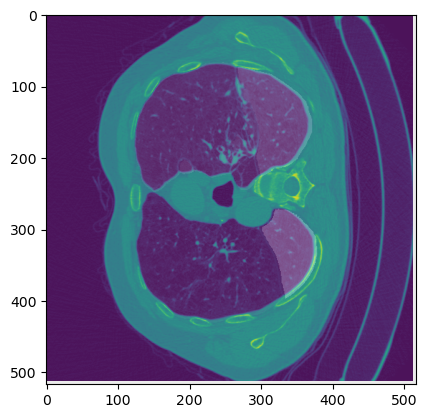

In [15]:
img = np.load(dic_paths[310][0])
print(np.unique(img))
img += 5
img /= np.max(img)
ds = mage_data[:,:,310]
print(np.shape(img),np.shape(ds))
plt.imshow(ds,alpha=1.0)
plt.imshow(img,alpha=0.3)
plt.show()

In [16]:
img = np.load(dic_paths[310][0])
class_ = np.unique(img[:,:,3])
class_

array([0., 1., 2., 3., 4., 5.])

In [17]:
class_ = class_[np.newaxis, 1:]
class_

array([[1., 2., 3., 4., 5.]])

In [18]:
np.shape((img[:,:,3][:,:,np.newaxis] == class_).astype(int))

(517, 517, 5)

(517, 517) (512, 512)


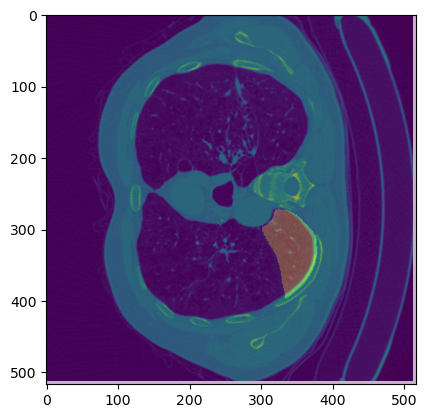

In [19]:
img_ = (img[:,:,3][:,:,np.newaxis] == class_).astype(int)[...,4]
ds = mage_data[:,:,310]
print(np.shape(img_),np.shape(ds))
plt.imshow(ds,alpha=1.0)
plt.imshow(img_,alpha=0.3)
plt.show()

In [20]:
len([e for e in range(0, 512, 2)])

256

In [21]:
def change_size(arr):
    mask = [e for e in range(0, np.shape(arr)[0], 2)]
    tmp = arr[mask,:,:]
    return tmp[:,mask,:]

In [22]:
import random

def thresh(x):
    if x == 0:
        return 0
    else:
        return 1
    
    
def create_datasets(x_data, y_data, pr = 0.2):
    x = []
    y = []
    x_val = []
    y_val = []
    pbar_images = tqdm_step(range(np.shape(x_data)[2]), desc="Images")
    for idx in pbar_images:
        if idx+1 in y_data.keys():
            y_d = (np.array(np.load(y_data[idx+1][0]), dtype=np.float16)[:,:,0][:,:,np.newaxis] == class_).astype(int)
            y_mx = y_d if np.shape(y_d)[1] == 512 else y_d[0:512,4:516,:]
            x_mx = change_size(change_size(np.array(x_data[:,:,idx][:,:, np.newaxis], dtype=np.float16)))
            if random.random() <= 0.2:
                y_val.append(y_mx)
                x_val.append(x_mx)
            else:
                y.append(y_mx)
                x.append(x_mx)
    return np.array(x), np.array(y), np.array(x_val), np.array(y_val)

x_train, y_train, x_val, y_val = create_datasets(mage_data, dic_paths)

Images:   0%|          | 0/464 [00:00<?, ?it/s]

In [23]:
np.shape(x_train)

(382, 128, 128, 1)

In [24]:
x_train = np.moveaxis(x_train, -1,1)
y_train = np.moveaxis(y_train, -1,1)

In [25]:
np.shape(y_train)

(382, 5, 512, 512)

In [26]:
x_val = np.moveaxis(x_val, -1,1)
y_val = np.moveaxis(y_val, -1,1)

In [96]:
x_train_class = []
y_train_class = []
x_val_class = []
y_val_class = []
x_train_mask = []
x_val_mask = []

In [97]:
np.shape(x_val)

(79, 1, 128, 128)

In [98]:
pos_1 = False
pos_2 = False

In [99]:
def get_class_ds(x, y, pos_1, pos_2, x_train_class, y_train_class, x_val_class, y_val_class, mask):
    for idx, cls in enumerate((np.sum(np.sum(np.sum(y, axis=1), axis=1), axis=1) == 0).astype(int)):
        val = x[idx, ...].flatten(order='C')
        mask.append(val)
        if (cls == 1):
            if pos_2:
                x_train_class.append(val)
                y_train_class.append(cls)
            else:            
                x_val_class.append(val)
                y_val_class.append(cls)
            pos_2 = not pos_2
        else:
            if pos_1:
                x_train_class.append(val)
                y_train_class.append(cls)
            else:            
                x_val_class.append(val)
                y_val_class.append(cls)
            pos_1 = not pos_1

In [100]:
%%time
get_class_ds(x_train, y_train, pos_1, pos_2, x_train_class, y_train_class, x_val_class, y_val_class, x_train_mask)
get_class_ds(x_val, y_val, pos_1, pos_2, x_train_class, y_train_class, x_val_class, y_val_class, x_val_mask)

CPU times: user 2.3 s, sys: 51.7 ms, total: 2.36 s
Wall time: 2.36 s


In [101]:
x_train_class = np.array(x_train_class)
y_train_class = np.array(y_train_class)
x_val_class = np.array(x_val_class)
y_val_class = np.array(y_val_class)
x_train_mask = np.array(x_train_mask)
x_val_mask = np.array(x_val_mask)

In [33]:
np.shape(x_train_class)

(230, 16384)

In [34]:
np.shape(x_val_class)

(233, 16384)

In [35]:
np.shape(y_train_class)

(230,)

In [36]:
np.shape(y_val_class)

(233,)

In [37]:
(np.sum(np.sum(np.sum(y_train, axis=1), axis=1), axis=1) == 0).astype(int)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:
y_train_class

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [39]:
(np.sum(np.sum(np.sum(y_val, axis=1), axis=1), axis=1) == 0).astype(int)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [40]:
y_val_class

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
#clf.fit(x_train_class, y_train_class)
clf.fit(x_train_class, y_train_class)
scores = cross_val_score(clf, x_val_class, y_val_class, cv=5)
print(scores.mean())

clf = RandomForestClassifier(n_estimators=12, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(x_train_class, y_train_class)
scores = cross_val_score(clf, x_val_class, y_val_class, cv=5)
print(scores.mean())

clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(x_train_class, y_train_class)
scores = cross_val_score(clf, x_val_class, y_val_class, cv=5)
print(scores.mean())
print(scores.mean() > 0.999)

0.9359851988899168
0.9827937095282147
0.9827937095282147
False


In [42]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()

In [43]:
cat.fit(x_train_class,y_train_class,eval_set=(x_val_class, y_val_class),verbose=False, plot=True, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [87]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val_class, cat.predict(x_val_class))

0.9914163090128756

In [88]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val_class, cat.predict_proba(x_val_class)[:,1])

0.9970238095238095

In [89]:
y_val_class != (cat.predict_proba(x_val_class)[:,1] > 0.035).astype(int)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [90]:
cat.predict_proba(x_val_class)[:,1]

array([0.01837939, 0.0196807 , 0.01037145, 0.00989019, 0.00786617,
       0.01070599, 0.00884371, 0.00785543, 0.00936716, 0.0062425 ,
       0.00784466, 0.00775116, 0.00630565, 0.00605204, 0.00619264,
       0.00613565, 0.00839641, 0.00671819, 0.01133287, 0.00537708,
       0.00603807, 0.00572899, 0.00786294, 0.0053057 , 0.00632285,
       0.00763696, 0.00439689, 0.00522089, 0.00467766, 0.00468786,
       0.00655646, 0.00311542, 0.00478996, 0.00511848, 0.00542496,
       0.00550071, 0.00477595, 0.00349132, 0.00407859, 0.0044251 ,
       0.00352306, 0.00409179, 0.00370486, 0.00379361, 0.00446987,
       0.00419164, 0.00361174, 0.00433645, 0.00334314, 0.00409195,
       0.00341499, 0.00397258, 0.00274508, 0.0027589 , 0.00339658,
       0.00313229, 0.00351382, 0.00382464, 0.00342994, 0.00453825,
       0.00392986, 0.00342986, 0.0044832 , 0.00319347, 0.003669  ,
       0.00306297, 0.00313382, 0.003408  , 0.00253257, 0.00265404,
       0.00339873, 0.00424806, 0.00304537, 0.00426078, 0.00356

In [91]:
y_train_class != cat.predict(x_train_class)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [92]:
y_val_class != cat.predict(x_val_class)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [93]:
x_train.shape, y_train.shape

((369, 1, 128, 128), (369, 5, 512, 512))

In [94]:
x_val.shape, y_val.shape

((79, 1, 128, 128), (79, 5, 512, 512))

In [102]:
x_train_mask = cat.predict(x_train_mask)
x_val_mask = cat.predict(x_val_mask)

In [103]:
arg_idx = 0
for idx, val in enumerate(x_train_mask):
    if val == 1:
        arg_idx = idx
        break

In [104]:
x_train_mask[:arg_idx+1] = 1

In [105]:
x_train_mask[20:-20] = 0
x_train_mask

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [106]:
x_val_mask

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [107]:
(np.sum(np.sum(np.sum(y_train, axis=1), axis=1), axis=1) == 0).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [108]:
(np.sum(np.sum(np.sum(y_val, axis=1), axis=1), axis=1) == 0).astype(int)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [109]:
np.shape(x_train_mask)

(369,)

In [110]:
x_train_mask == 0

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [111]:
np.shape(x_train)

(369, 1, 128, 128)

In [112]:
np.shape(x_train[x_train_mask == 0, :,:,:])

(368, 1, 128, 128)

In [113]:
x_train = x_train[x_train_mask == 0, :,:,:]
y_train = y_train[x_train_mask == 0, :,:,:]
x_val = x_val[x_val_mask == 0, :,:,:]
y_val = y_val[x_val_mask == 0, :,:,:]

In [114]:
np.shape(x_train), np.shape(y_train), np.shape(x_val), np.shape(y_val)

((368, 1, 128, 128), (368, 5, 512, 512), (79, 1, 128, 128), (79, 5, 512, 512))

In [115]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

In [147]:
batch_size = 4
epochs = 10
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [117]:
def metric_delta_cross(y_true, pred, device):
    mask = (y_true == 1)
    pred_outer = pred.clone().detach()
    mask_field = torch.Tensor(np.ones(y_true.shape)).to(device)
    pred_outer[mask] = 0
    mask_field[mask] = 0
    pred[~mask] = 0
    outer = 1 - (torch.sum(torch.sum(torch.sum(pred_outer, dim=1), dim=1), dim=1)+1e-16) / (torch.sum(torch.sum(torch.sum(mask_field, dim=1), dim=1), dim=1)+1e-16)
    inner = 1 - (torch.sum(torch.sum(torch.sum(torch.abs(y_true - pred), dim=1), dim=1), dim=1)+1e-16) / (torch.sum(torch.sum(torch.sum(mask.long(), dim=1), dim=1), dim=1)+1e-16)
    metric = torch.mean((outer + inner) / 2)
    return torch.Tensor([0]) if metric < 0 else metric

In [118]:
torch.Tensor([0]).detach()

tensor([0.])

In [119]:
class ASPPBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=(1, 1), in_channels=channels, out_channels=channels, padding=0)
        self.conv2 = torch.nn.Conv2d(kernel_size=(3, 3), in_channels=channels, out_channels=channels, padding=6, dilation=(6, 6))
        #self.conv3 = torch.nn.Conv2d(kernel_size=(3, 3), in_channels=channels, out_channels=channels, padding=12, dilation=(12,12))
        #self.conv4 = torch.nn.Conv2d(kernel_size=(3, 3), in_channels=channels, out_channels=channels, padding=18, dilation=(18,18))
        self.conv5 = torch.nn.Conv2d(kernel_size=(1, 1), in_channels=channels*2, out_channels=channels)
        
    def forward(self, inp):
        out1 = torch.nn.functional.relu(self.conv1(inp))
        #print(f"out1",np.shape(out1))
        out2 = torch.nn.functional.relu(self.conv2(inp))
        #print(f"out2",np.shape(out2))
        #out3 = torch.nn.functional.relu(self.conv3(inp))
        #print(f"out3",np.shape(out3))
        #out4 = torch.nn.functional.relu(self.conv4(inp))
        #print(f"out4",np.shape(out4))
        #out = torch.cat((out1, out2, out3, out4), dim=1)
        out = torch.cat((out1, out2), dim=1)
        #print(f"out",np.shape(out))
        out = torch.nn.functional.relu(self.conv5(out))
        return out

In [120]:
class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(out_channels)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        return out

In [121]:
class Bottlenack(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=in_channels*2, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(in_channels*2)
        self.conv2 = torch.nn.Conv2d(kernel_size=3, in_channels=in_channels*2, out_channels=in_channels*2, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(in_channels*2)
        self.conv3 = torch.nn.ConvTranspose2d(kernel_size=3, in_channels=in_channels*2, out_channels=in_channels,stride=2, padding=1, output_padding=1)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.nn.functional.relu(self.conv3(out))
        return out

In [122]:
class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        mid_channel = min(in_channels, out_channels) + max(in_channels, out_channels) - min(in_channels, out_channels)
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(mid_channel)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(mid_channel)
        self.conv3 = torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.nn.functional.relu(self.conv3(out))
        return out

In [123]:
class FinalBlock(nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, kernel_size=3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(mid_channel)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(mid_channel)
        self.conv3 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.nn.functional.sigmoid(self.conv3(out))
        return out

In [124]:
class UNet(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.conv1 = DownSampling(in_channels, 64, 3)
        self.conv2 = DownSampling(64, 128, 3)
        self.conv3 = DownSampling(128, 256, 3)
        self.bottleneck = Bottlenack(256)
        self.convT1 = UpSampling(in_channels=256,out_channels=192, kernel_size=3)
        self.convT2 = UpSampling(in_channels=192,out_channels=128, kernel_size=3)
        self.convT3 = UpSampling(in_channels=128,out_channels=96,  kernel_size=3)
        self.convT4 = UpSampling(in_channels=96, out_channels=64,  kernel_size=3)
        self.aspp = ASPPBlock(64)
        self.final = FinalBlock(64, 16, out_channels)
        self.conv_maxpool = torch.nn.MaxPool2d(kernel_size=2)
    
    def forward(self, x):
        #print(np.shape(x))
        x = self.conv1(x)
        x = self.conv_maxpool(x)
        #print(f"conv1", np.shape(x))
        x = self.conv2(x)
        x = self.conv_maxpool(x)
        #print(f"conv2", np.shape(x))
        x = self.conv3(x)
        x = self.conv_maxpool(x)
        #print(f"conv3", np.shape(x))
        x = self.bottleneck(x)
        #print(f"bottleneck", np.shape(x))
        x = self.convT1(x)
        #print(f"convT1", np.shape(x))
        x = self.convT2(x)
        #print(f"convT2", np.shape(x))
        x = self.convT3(x)
        #print(f"convT3", np.shape(x))
        x = self.convT4(x)
        #print(f"convT4", np.shape(x))
        #x = self.aspp(x)
        #print(f"aspp", np.shape(x))
        x = self.final(x)
        #print(f"final", np.shape(x))
        return x

In [125]:
def step(inputs, labels, optimizer, criterion, device, is_train=True):
    #if is_train:
    optimizer.zero_grad()

    outputs = unet(inputs)
    outputs = outputs.permute(0, 2, 3, 1)
    labels = labels.permute(0, 2, 3, 1)
    
    loss = criterion(outputs, labels.float())
    
    if is_train:
        loss.backward()
        optimizer.step()
    return loss.item(), metric_delta_cross(labels, outputs, device).item()

In [76]:
learning_rate = 0.0001

In [77]:
device = torch.device(params['device'] if torch.cuda.is_available() else 'cpu')

In [78]:
unet = UNet(in_channels=1,out_channels=np.shape(class_)[-1])
if use_gpu:
    unet = unet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr = learning_rate)

In [79]:
acc_train_total = []
loss_train_total = []
acc_val_total = []
loss_val_total = []

In [80]:
try:
    print(unet.load_state_dict(torch.load('./best_model_2.mdl')))
except:
    print("Модель не загрузилась")

<All keys matched successfully>


In [81]:
acc_train_total = list(np.load('acc_train_total_2.npy'))
loss_train_total = list(np.load('loss_train_total_2.npy'))
acc_val_total = list(np.load('acc_val_total_2.npy'))
loss_val_total = list(np.load('loss_val_total_2.npy'))

In [161]:
learning_rate = 0.000005

In [144]:
criterion = nn.BCELoss()

In [145]:
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

In [146]:
list(loss_val_total)

[0.47187638903657597,
 0.44093751286466915,
 0.30638726986944675,
 0.2632301102081935,
 0.2789397779852152,
 0.9504913538694382,
 0.3366727354004979,
 0.574401483250161,
 0.35592587664723396,
 0.5051015547166268,
 0.5257102868830165,
 0.3213103273883462,
 0.46625941526144743,
 0.8652480572151641,
 0.6186613927905759,
 0.14391836834450564,
 0.7236111843958497,
 0.5296187453592817,
 0.14697997768719992,
 0.7177626794824997,
 0.2923928184124331,
 0.6922253717202693,
 0.5105049754492939,
 1.1622134762195249,
 0.5299900787261626,
 0.2932791538381328,
 0.8954235023120418,
 0.7699984233671179,
 3.6159926414256915,
 0.6827568921338146,
 0.8312344360553349,
 0.4329816567866753,
 0.45026584951362264,
 0.4676247138995677,
 0.5775028426432982,
 0.5825420207887267,
 0.44374677154701203,
 0.38821156256987405,
 0.5405523659428582,
 0.6297115824806193,
 0.29437998895688605,
 0.32389222042790305,
 0.39017341429522884,
 0.4151144647039473,
 0.5980187727836892,
 0.9216219349958313,
 0.5517609727491314,
 

In [162]:
%%time
#unet.train()
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
epoch_iter_val = np.ceil(x_val.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
acc_train = []
loss_train = []
acc_val = []
loss_val = []
batch_loss = 0
metric_acc = 0
pbar_epochs = tqdm_step(t, desc="Epochs")
for _ in pbar_epochs:
    unet.train()
    pbar_steps = tqdm_step(range(epoch_iter), desc="Training")
    bar_train_loss = []
    bar_train_acc = []
    for i in pbar_steps:
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size, ...]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.to(device)
            batch_train_y = batch_train_y.to(device)
        batch_loss, metric_acc = step(batch_train_x, batch_train_y, optimizer, criterion, device, is_train=True)
        bar_train_loss.append(batch_loss)
        bar_train_acc.append(metric_acc)
        pbar_steps.postfix = f"loss = {batch_loss}, acc = {metric_acc*100}%, acc_mean = {np.mean(bar_train_acc)}%"     
        torch.cuda.empty_cache()
        gc.collect()
    loss_train.append(np.mean(bar_train_loss))
    acc_train.append(np.mean(bar_train_acc))
    
    unet.eval()
    with torch.no_grad():
        pbar_vals = tqdm_step(range(epoch_iter_val), desc="Predicting")
        bar_val_loss = []
        bar_val_acc = []
        for i in pbar_vals:
            try:
                batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size, ...]).float()
                batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size]).long()
                if use_gpu:
                    batch_val_x = batch_val_x.to(device)
                    batch_val_y = batch_val_y.to(device)
                batch_loss, metric_acc = step(batch_val_x, batch_val_y, optimizer, criterion, device, is_train=False)
                bar_val_loss.append(batch_loss)
                bar_val_acc.append(metric_acc)
                pbar_vals.postfix = f"loss = {batch_loss},  acc = {metric_acc*100}%, acc_mean = {np.mean(bar_val_acc)}%"
                torch.cuda.empty_cache()
                gc.collect()
            except Exception as e:
                print(e)
    loss_val.append(np.mean(bar_val_loss))
    acc_val.append(np.mean(bar_val_acc))
    pbar_epochs.postfix = f"train_loss = {loss_train[-1]}, train_acc = {acc_train[-1]*100}%, val_loss = {loss_val[-1]}, val_acc = {acc_val[-1]*100}%"
acc_train_total.append(acc_train)
loss_train_total.append(loss_train)
acc_val_total.append(acc_val)
loss_val_total.append(loss_val)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [00:52<07:48, 52.10s/it]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

 20%|████████▊                                   | 2/10 [01:44<06:58, 52.31s/it]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

 30%|█████████████▏                              | 3/10 [02:37<06:08, 52.59s/it]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

 40%|█████████████████▌                          | 4/10 [03:30<05:16, 52.74s/it]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

 50%|██████████████████████                      | 5/10 [04:23<04:24, 52.97s/it]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████████████████████████▍                 | 6/10 [05:16<03:30, 52.75s/it]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

 70%|██████████████████████████████▊             | 7/10 [06:08<02:38, 52.73s/it]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

 80%|███████████████████████████████████▏        | 8/10 [07:01<01:45, 52.60s/it]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

 90%|███████████████████████████████████████▌    | 9/10 [07:54<00:52, 52.80s/it]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 10/10 [08:47<00:00, 52.75s/it]

CPU times: user 10min 33s, sys: 1min 20s, total: 11min 53s
Wall time: 8min 47s


In [163]:
acc_train = [e if e >= 0 else 0 for e in acc_train]
loss_train = [e if e >= 0 else 0 for e in loss_train]

In [164]:
x = [e for e in range(len(np.hstack(acc_train_total)))]

In [165]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=11, figsize=(18,4*num_examples))
    m = datax.shape[0]
    p = 0.4
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        image_arr = image_arr/ np.max(image_arr)
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow((np.transpose(image_arr, (1,2,0))[:,:,0] > p).astype(int))
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow((np.transpose(image_arr, (1,2,0))[:,:,1] > p).astype(int))
        ax[row_num][2].set_title("Segmented Image")
        ax[row_num][3].imshow((np.transpose(image_arr, (1,2,0))[:,:,2] > p).astype(int))
        ax[row_num][3].set_title("Segmented Image")
        ax[row_num][4].imshow((np.transpose(image_arr, (1,2,0))[:,:,3] > p).astype(int))
        ax[row_num][4].set_title("Segmented Image")
        ax[row_num][5].imshow((np.transpose(image_arr, (1,2,0))[:,:,4] > p).astype(int))
        ax[row_num][5].set_title("Segmented Image")
        #print(np.shape(image_arr))
        img = np.argmax(np.transpose(image_arr, (1,2,0)), axis=-1)
        img += 5
        #print(np.shape(img), np.max(img))
        img = img / np.max(img)
        img *= 255
        #ax[row_num][6].imshow(img)
        #ax[row_num][6].set_title("Segmented Image localization")
        ax[row_num][6].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][6].set_title("Target image")
        ax[row_num][7].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,1])
        ax[row_num][7].set_title("Target image")
        ax[row_num][8].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,2])
        ax[row_num][8].set_title("Target image")
        ax[row_num][9].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,3])
        ax[row_num][9].set_title("Target image")
        ax[row_num][10].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,4])
        ax[row_num][10].set_title("Target image")
    plt.show()

In [166]:
def plot_examples_all(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,4*num_examples))
    m = datax.shape[0]
    p = 0.4
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        image_arr = image_arr/ np.max(image_arr)
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].imshow((np.transpose(image_arr, (1,2,0))[:,:,0] > p).astype(int), alpha=.2, cmap = 'gray')
        ax[row_num][0].imshow((np.transpose(image_arr, (1,2,0))[:,:,1] > p).astype(int), alpha=.2, cmap = 'RdPu_r')
        ax[row_num][0].imshow((np.transpose(image_arr, (1,2,0))[:,:,2] > p).astype(int), alpha=.2, cmap = 'BuGn_r')
        ax[row_num][0].imshow((np.transpose(image_arr, (1,2,0))[:,:,3] > p).astype(int), alpha=.2, cmap = 'YlGn')
        ax[row_num][0].imshow((np.transpose(image_arr, (1,2,0))[:,:,4] > p).astype(int), alpha=.2, cmap = 'coolwarm')
        ax[row_num][0].set_title("Predict")
        #print(np.shape(image_arr))
        img = np.argmax(np.transpose(image_arr, (1,2,0)), axis=-1)
        img += 5
        #print(np.shape(img), np.max(img))
        img = img / np.max(img)
        img *= 255
        #ax[row_num][6].imshow(img)
        #ax[row_num][6].set_title("Segmented Image localization")
        ax[row_num][1].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0], )
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0], alpha=.2, cmap = 'gray')
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,1], alpha=.2, cmap = 'RdPu_r')
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,2], alpha=.2, cmap = 'BuGn_r')
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,3], alpha=.2, cmap = 'YlGn')
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,4], alpha=.2, cmap = 'coolwarm')
        ax[row_num][1].set_title("Original")
    plt.show()

In [167]:
print("Максимальная точность на тренировочных примерах: ")
print("точность: " + str(np.max(np.hstack(acc_train_total))) + ", loss:" + str(np.max(np.hstack(loss_train_total))))

Максимальная точность на тренировочных примерах: 
точность: 0.9674925227528033, loss:0.4174561818663994


In [168]:
print("Максимальная точность на тестовых примерах: ")
print("точность: " + str(np.max(np.hstack(acc_val_total))) + ", loss:" + str(np.max(np.hstack(loss_val_total))))

Максимальная точность на тестовых примерах: 
точность: 0.8278697580099106, loss:3.6159926414256915


In [169]:
print("Средняя точность на тренировочных из 10 последних примеров: ")
print("точность: " + str(np.mean(np.hstack(acc_train_total[-10:-1]))) + ", loss:" + str(np.mean(np.hstack(loss_train_total[-10:-1]))))

Средняя точность на тренировочных из 10 последних примеров: 
точность: 0.9344601173687695, loss:0.011628830909475661


In [170]:
print("Средняя точность на тестовых из 10 последних примеров: ")
print("точность: " + str(np.mean(np.hstack(acc_val_total[-10:-1]))) + ", loss:" + str(np.mean(np.hstack(loss_val_total[-10:-1]))))

Средняя точность на тестовых из 10 последних примеров: 
точность: 0.7461905169290032, loss:0.4310426952487129


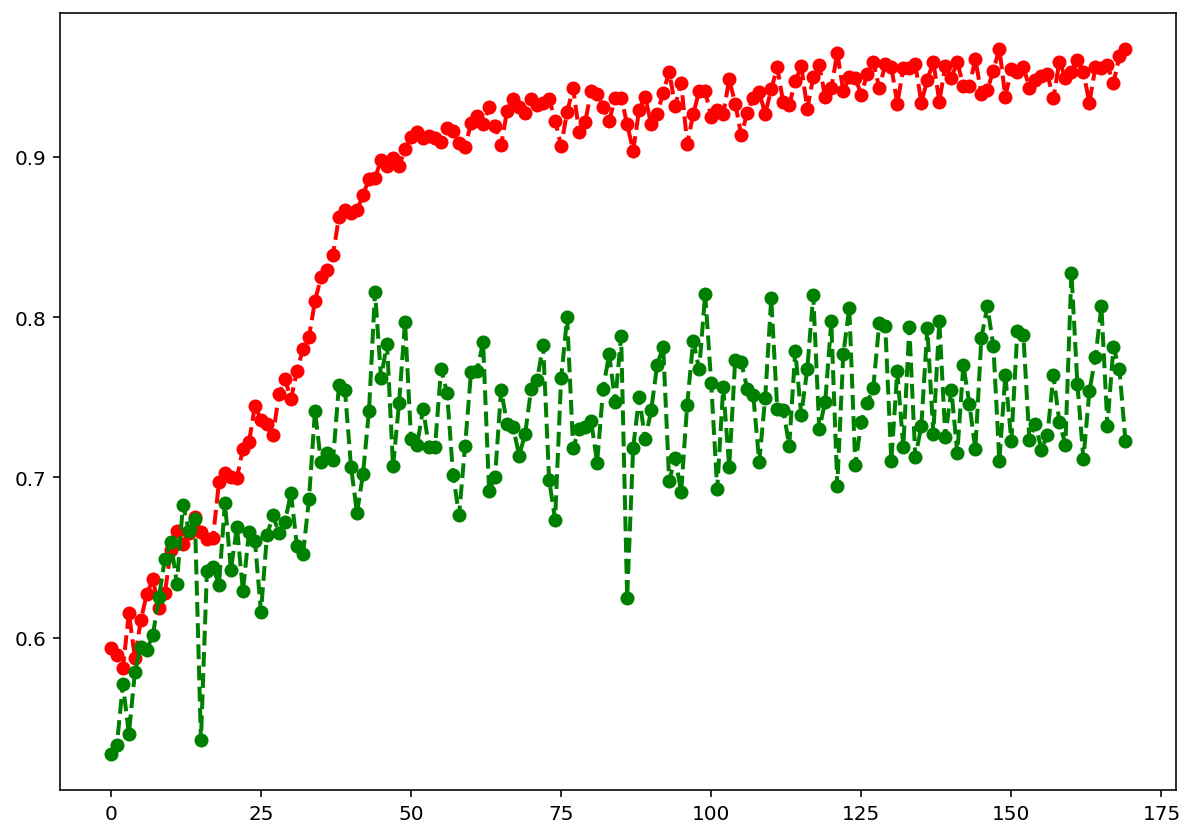

In [171]:
plt.figure(figsize=(10,7), dpi=144)
plt.plot(x, np.hstack(acc_train_total), color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.plot(x, np.hstack(acc_val_total), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.show()

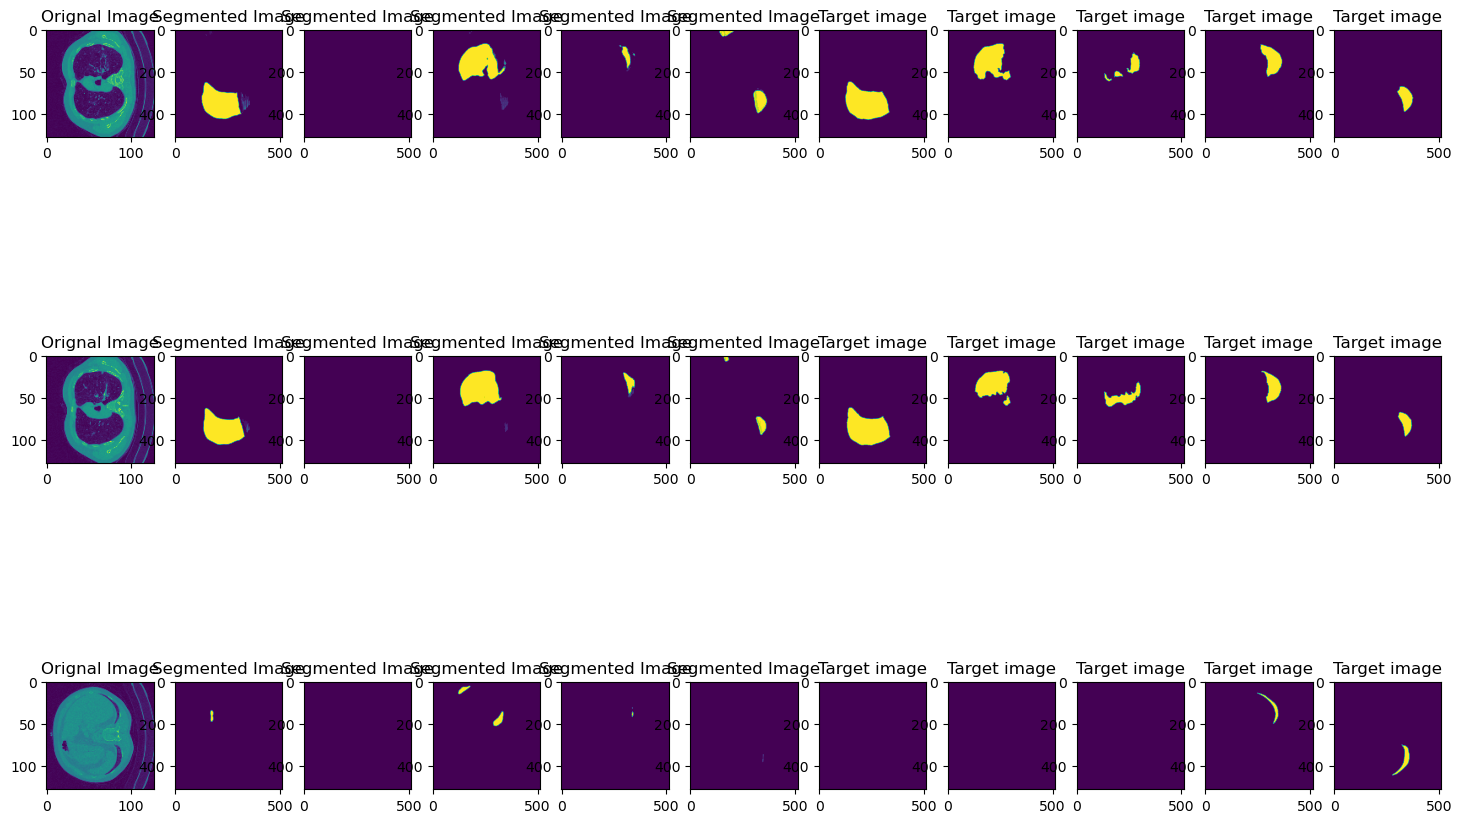

In [172]:
plot_examples(x_train, y_train)

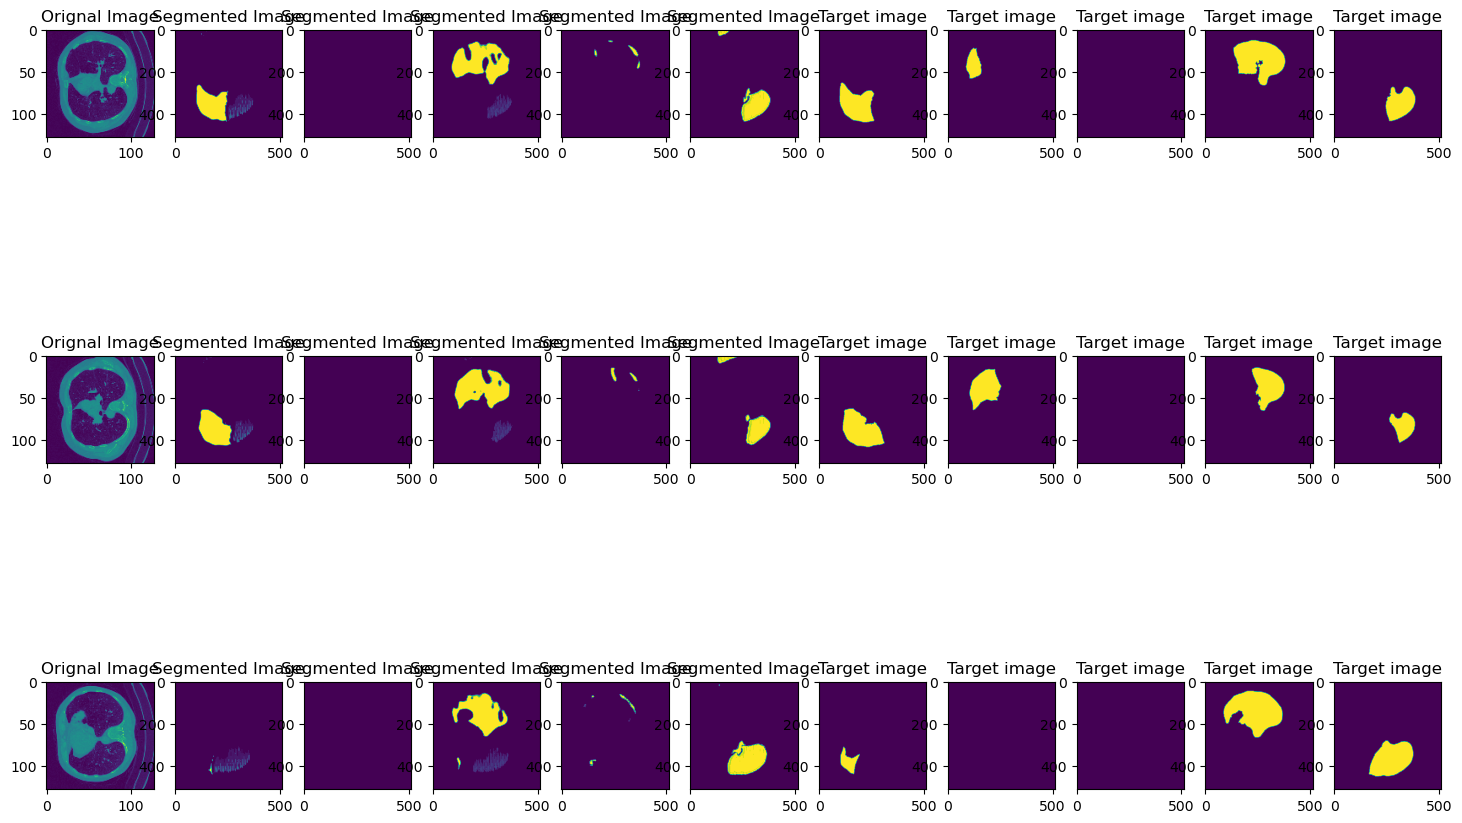

In [174]:
plot_examples(x_val, y_val)

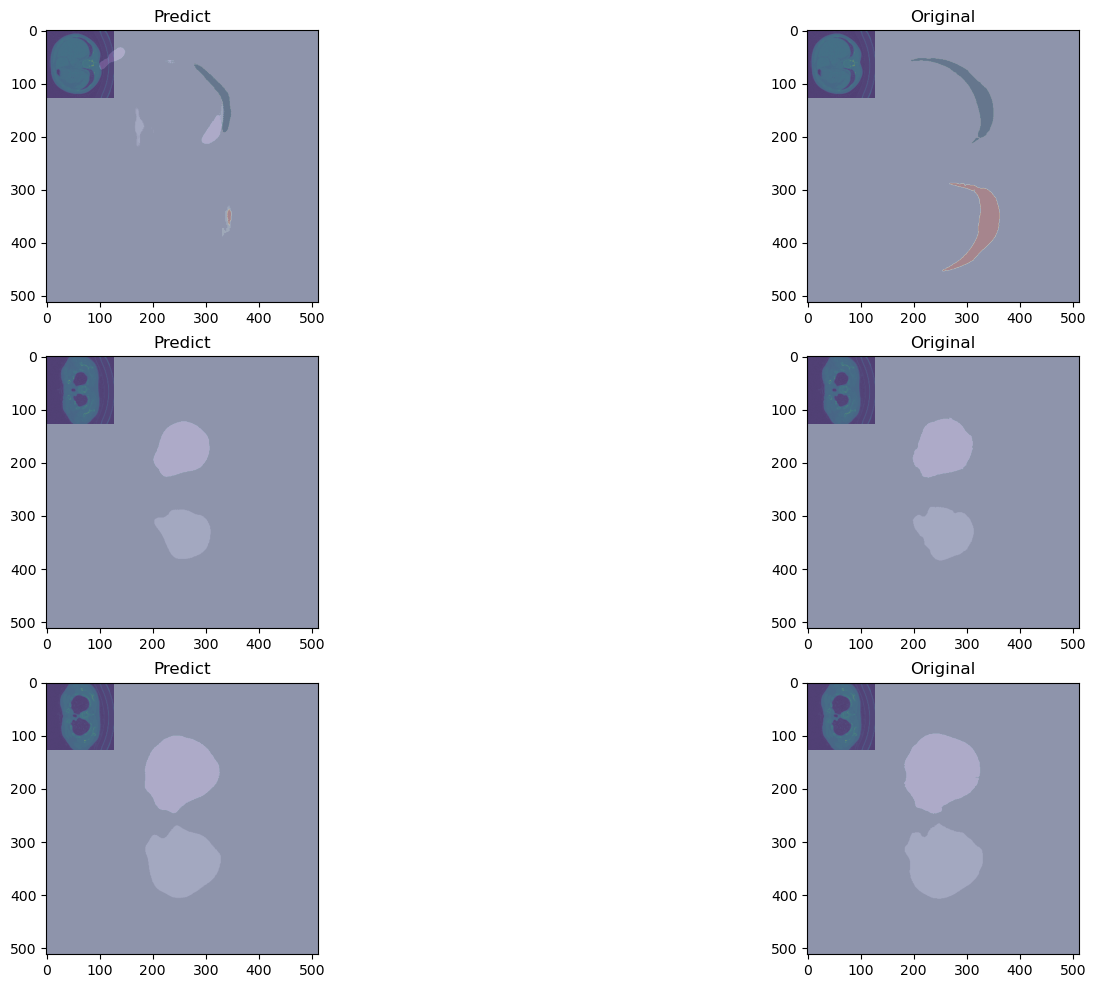

In [175]:
plot_examples_all(x_train, y_train)

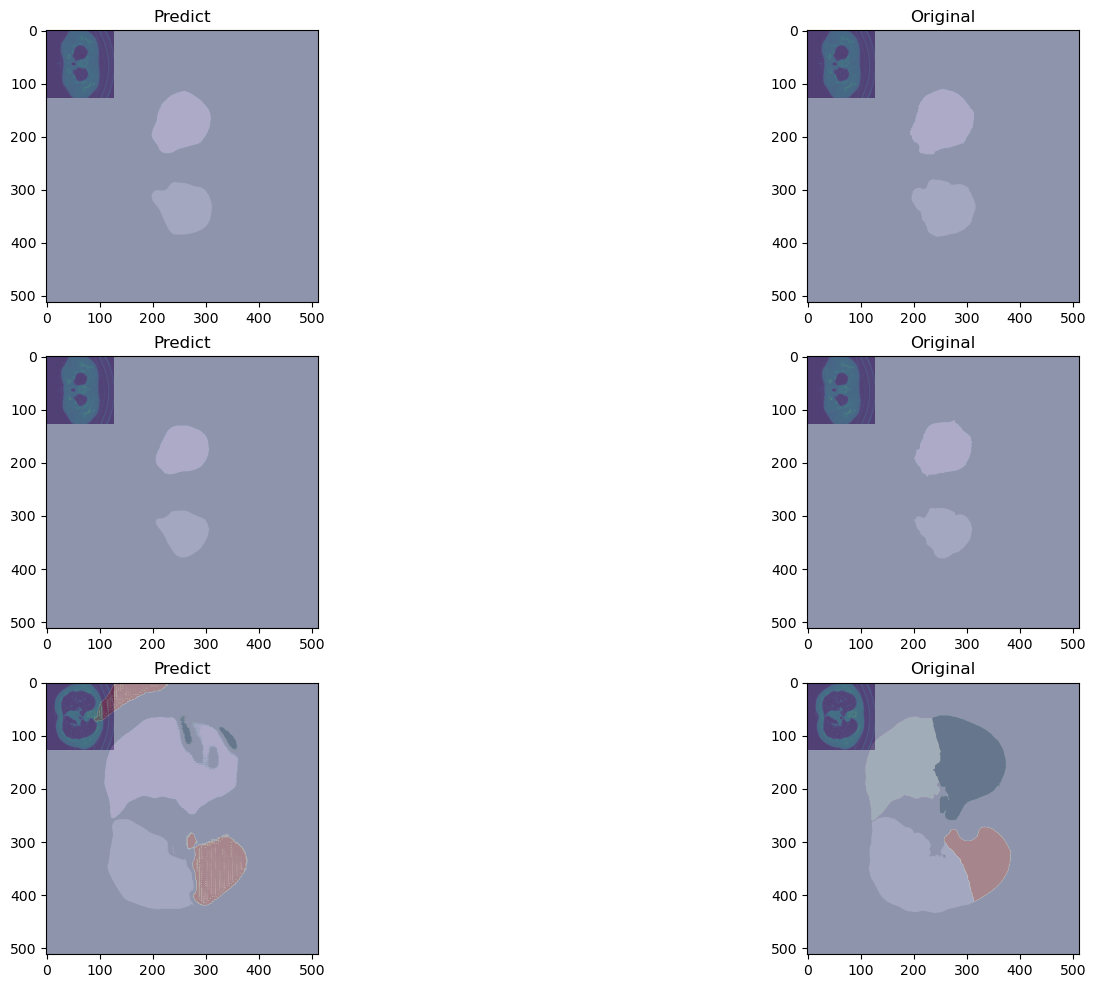

In [178]:
plot_examples_all(x_val, y_val)

In [76]:
print("Максимальная точность на тренировочных примерах: ")
print("точность: " + str(np.max(np.hstack(acc_train_total))) + ", loss:" + str(np.max(np.hstack(loss_train_total))))

Максимальная точность на тренировочных примерах: 
точность: 0.9471012562192896, loss:0.017070544717301215


In [77]:
print("Максимальная точность на тестовых примерах: ")
print("точность: " + str(np.max(np.hstack(acc_val_total))) + ", loss:" + str(np.max(np.hstack(loss_val_total))))

Максимальная точность на тестовых примерах: 
точность: 0.9157376910249392, loss:0.36939473496749997


In [78]:
print("Средняя точность на тренировочных из 10 последних примеров: ")
print("точность: " + str(np.max(np.hstack(acc_train_total[-10:-1]))) + ", loss:" + str(np.max(np.hstack(loss_train_total[-10:-1]))))

Средняя точность на тренировочных из 10 последних примеров: 
точность: 0.9420488289233004, loss:0.00910295363779839


In [79]:
print("Средняя точность на тестовых из 10 последних примеров: ")
print("точность: " + str(np.max(np.hstack(acc_val_total[-10:-1]))) + ", loss:" + str(np.max(np.hstack(loss_val_total[-10:-1]))))

Средняя точность на тестовых из 10 последних примеров: 
точность: 0.8577701577118465, loss:0.15786785890980223


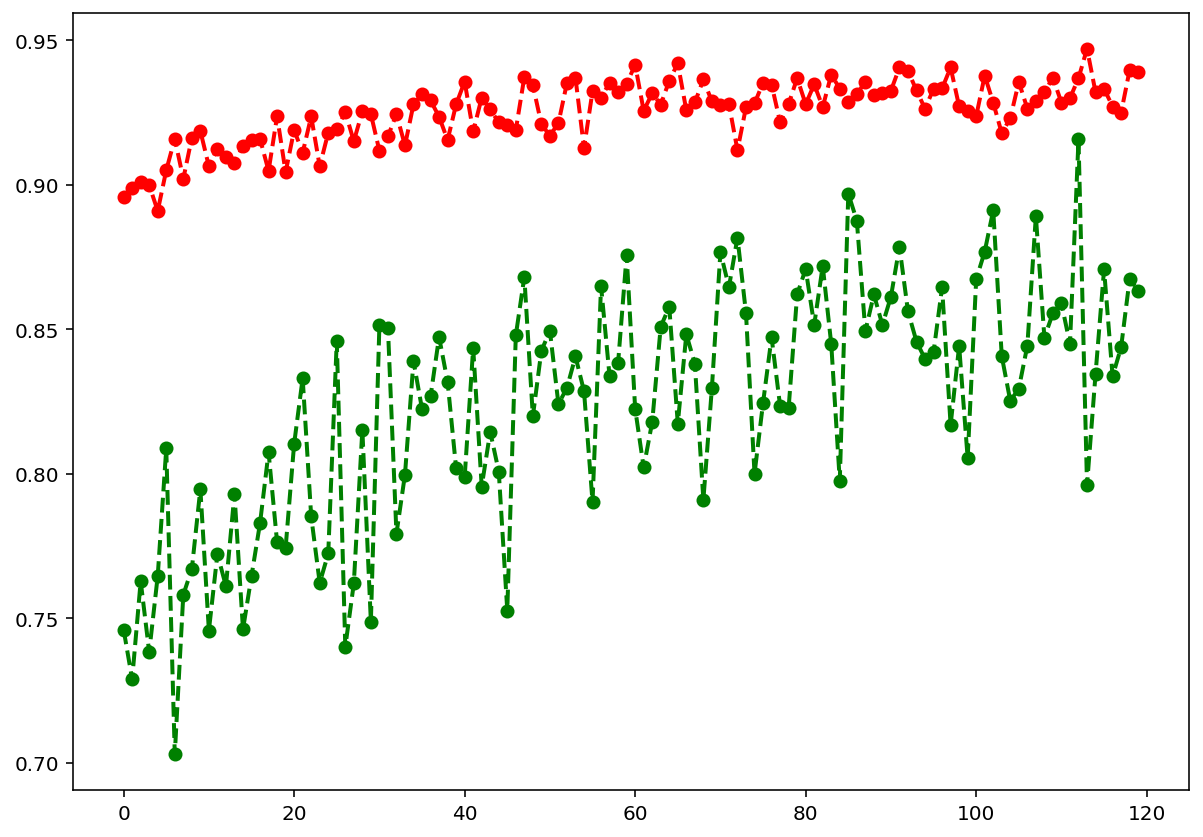

In [52]:
plt.figure(figsize=(10,7), dpi=144)
plt.plot(x, np.hstack(acc_train_total), color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.plot(x, np.hstack(acc_val_total), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.show()

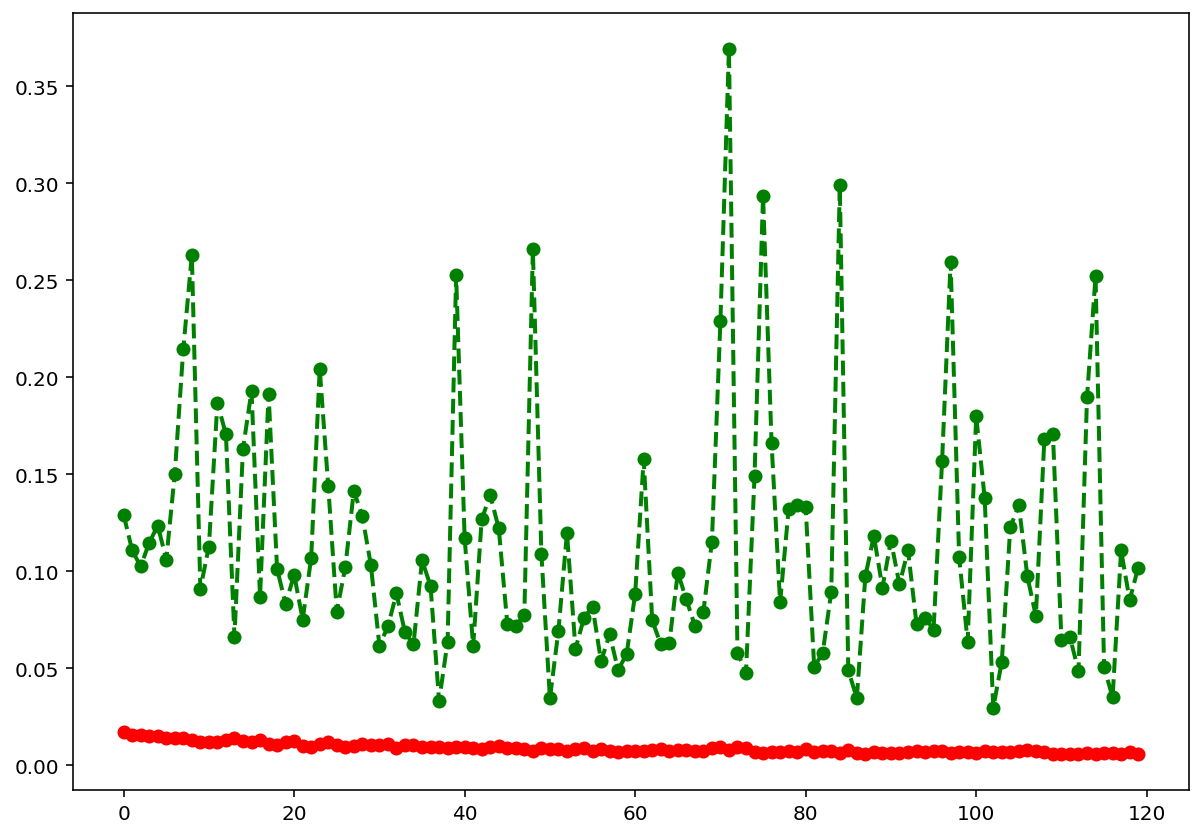

In [53]:
plt.figure(figsize=(10,7), dpi=144)
plt.plot(x, np.hstack(loss_train_total), color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.plot(x, np.hstack(loss_val_total), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.show()

In [150]:
#with open("./last.state", "w") as f:
#    f.write(json.dumps({"val_acc":val_acc.item()}))
if os.path.exists("./best_model_2.mdl"):
    os.rename('./best_model_2.mdl', f'./model_2_{1}.mdl')
torch.save(unet.state_dict(), './best_model_2.mdl')
print('Сохранено!')

Сохранено!


In [151]:
with open('acc_train_total_2.npy', 'wb') as f:
    np.save(f, np.hstack(acc_train_total))
with open('acc_val_total_2.npy', 'wb') as f:
    np.save(f, np.hstack(acc_val_total))
with open('loss_train_total_2.npy', 'wb') as f:
    np.save(f, np.hstack(loss_train_total))
with open('loss_val_total_2.npy', 'wb') as f:
    np.save(f, np.hstack(loss_val_total))

In [56]:
gc.collect()

6332

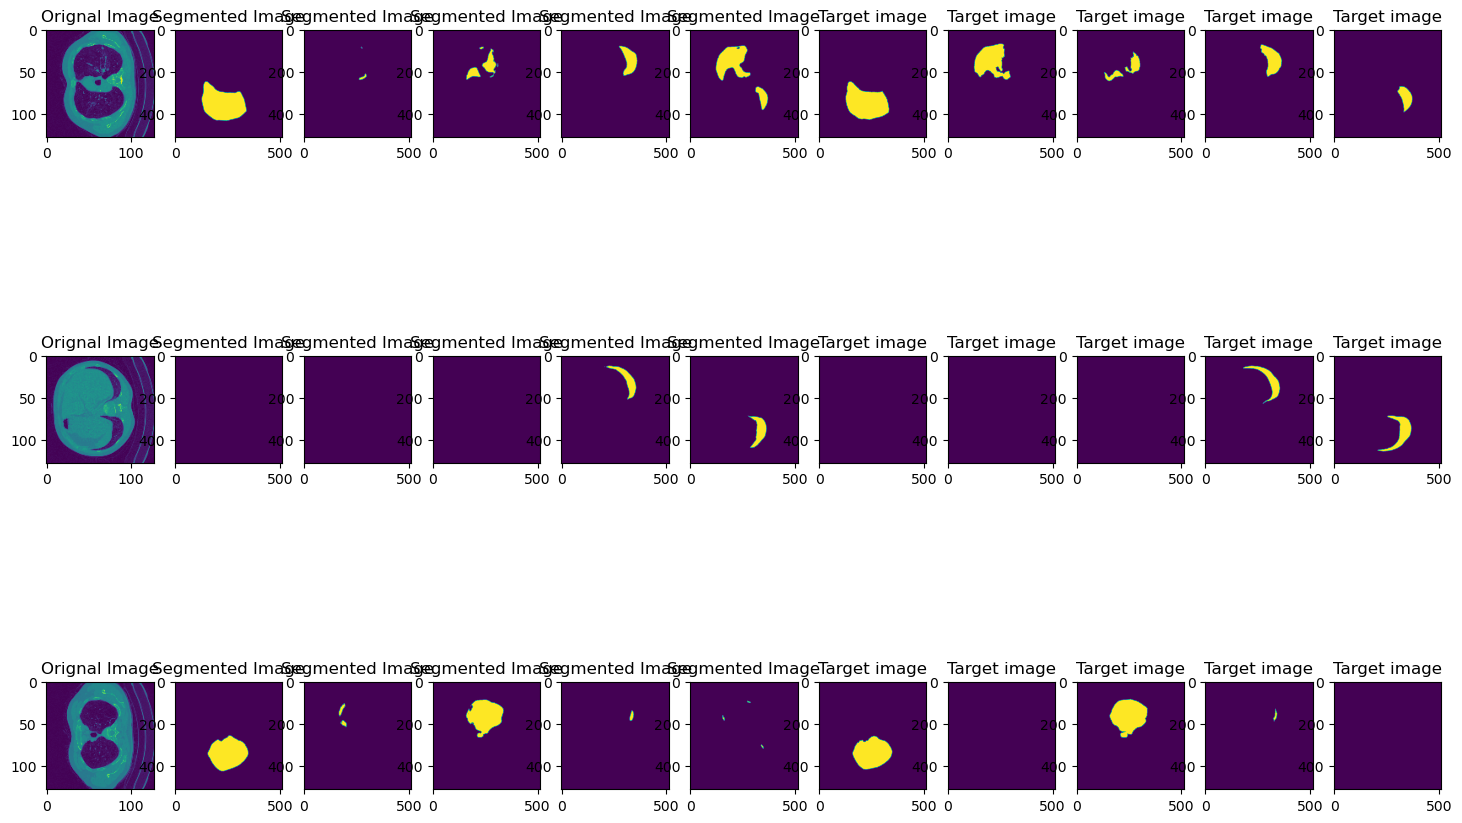

In [59]:
plot_examples(x_train, y_train)

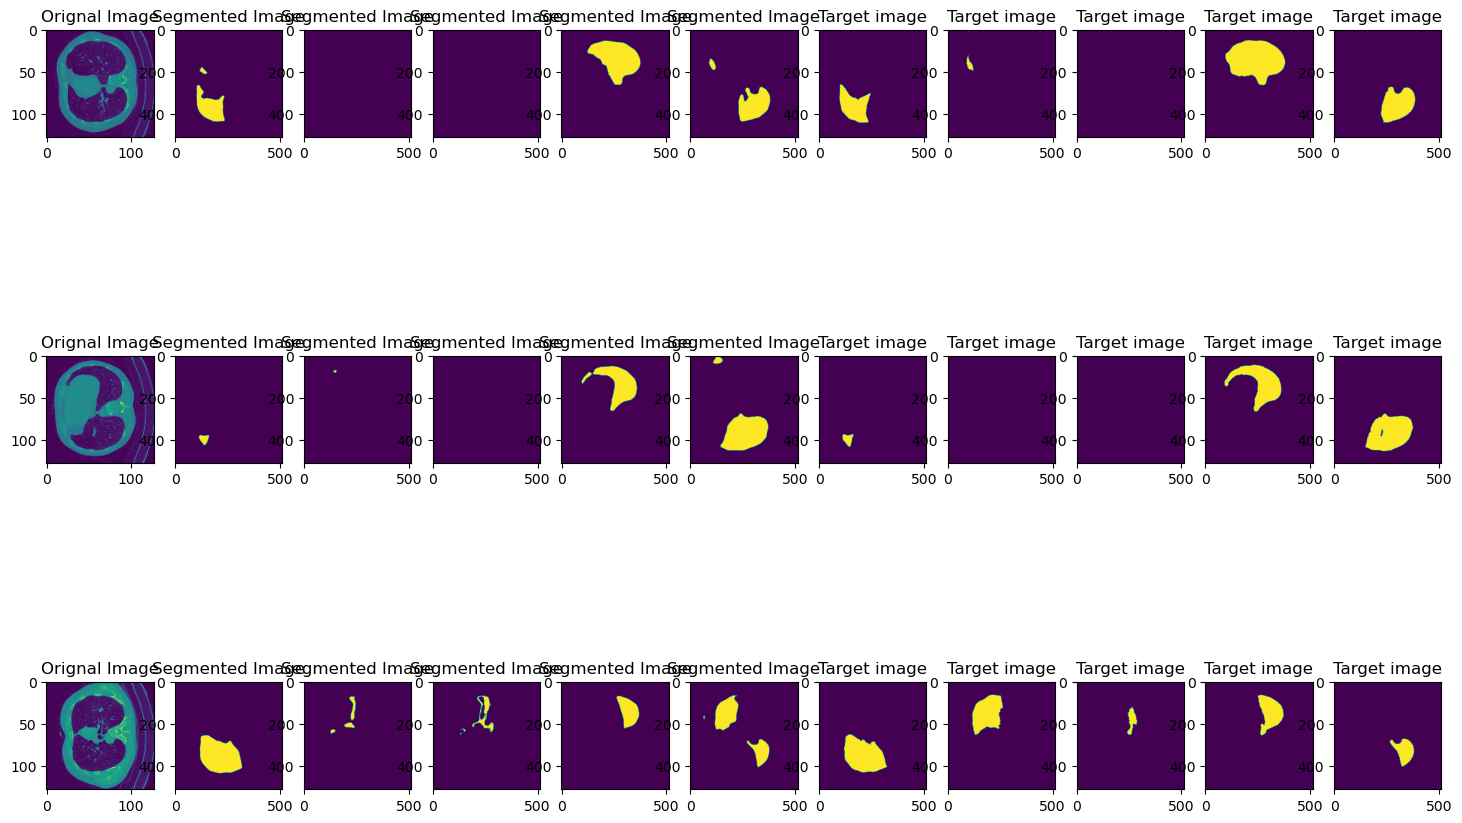

In [60]:
plot_examples(x_val, y_val)

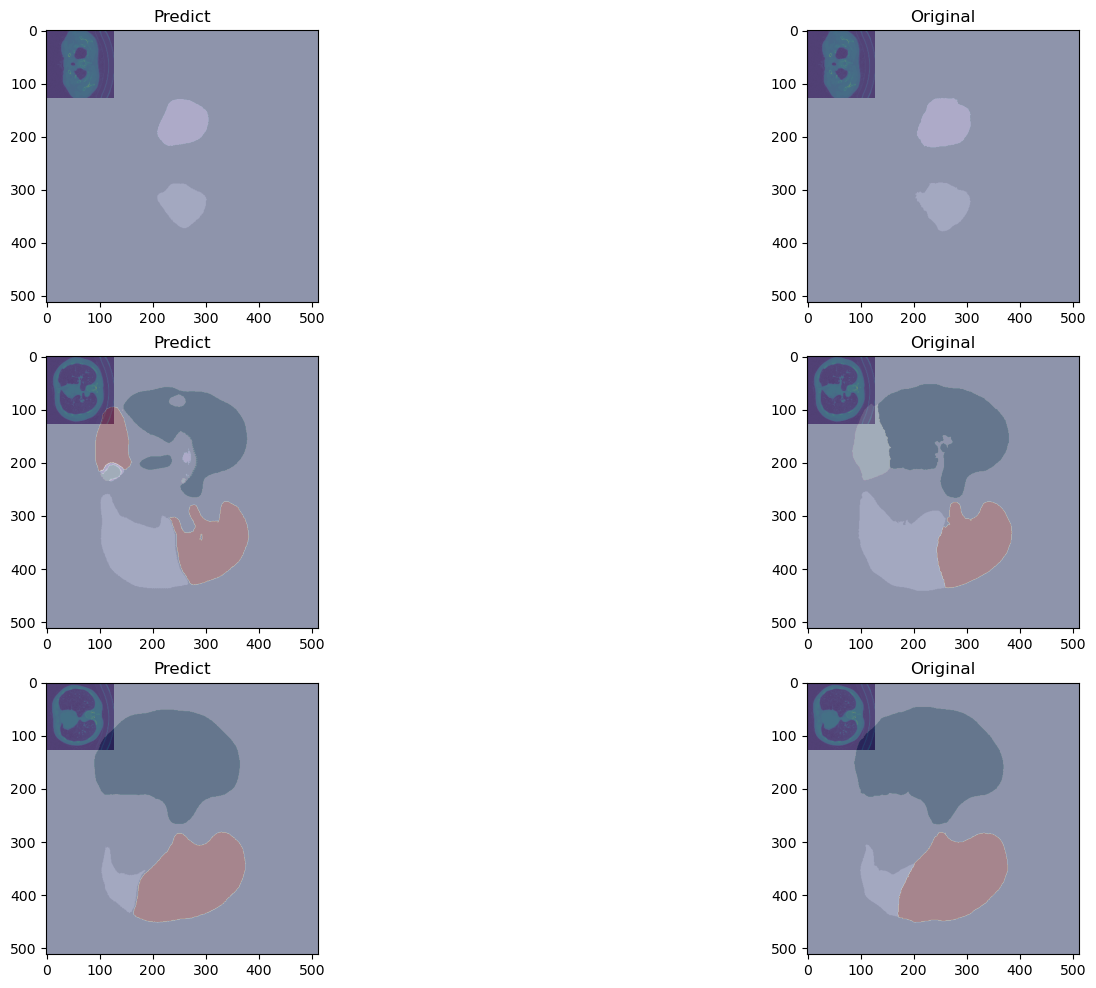

In [61]:
plot_examples_all(x_train, y_train)

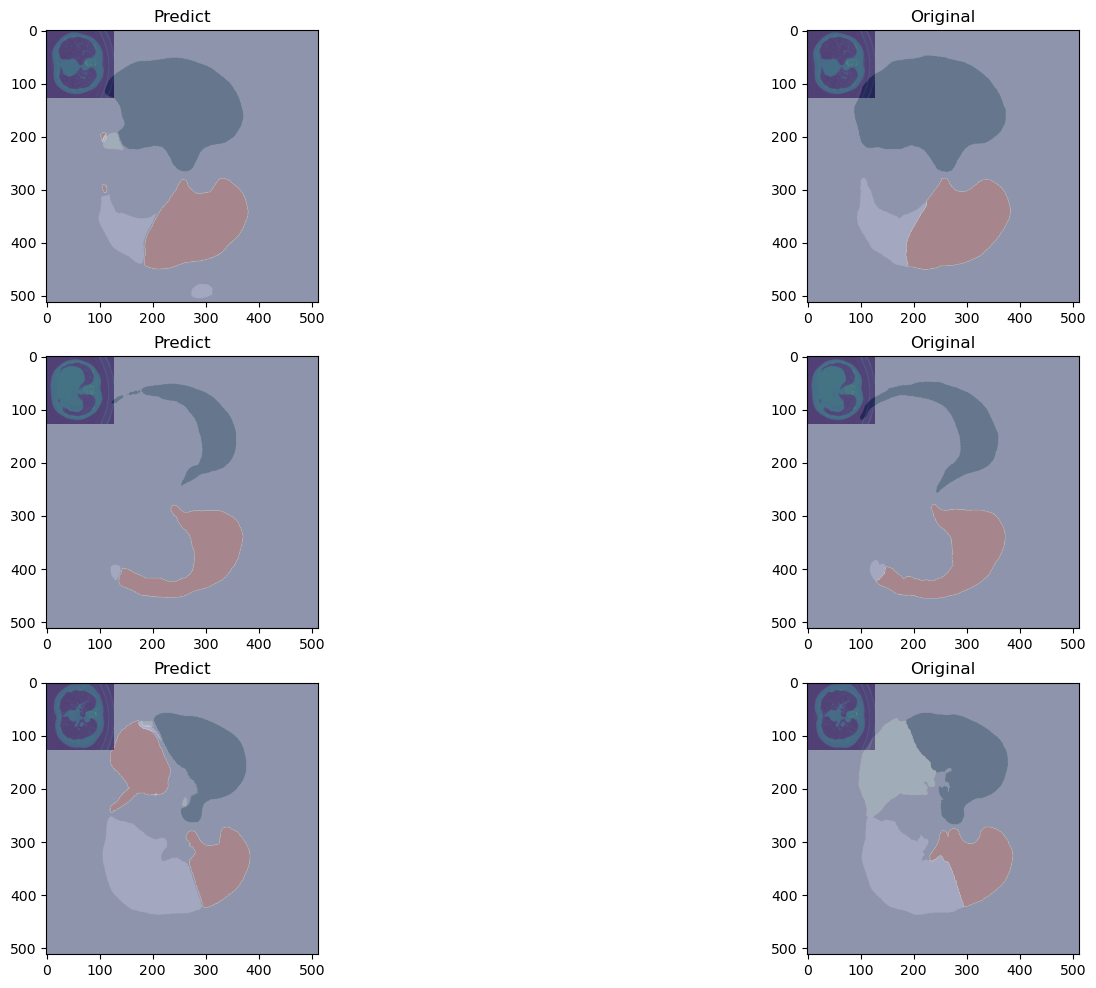

In [62]:
plot_examples_all(x_val, y_val)

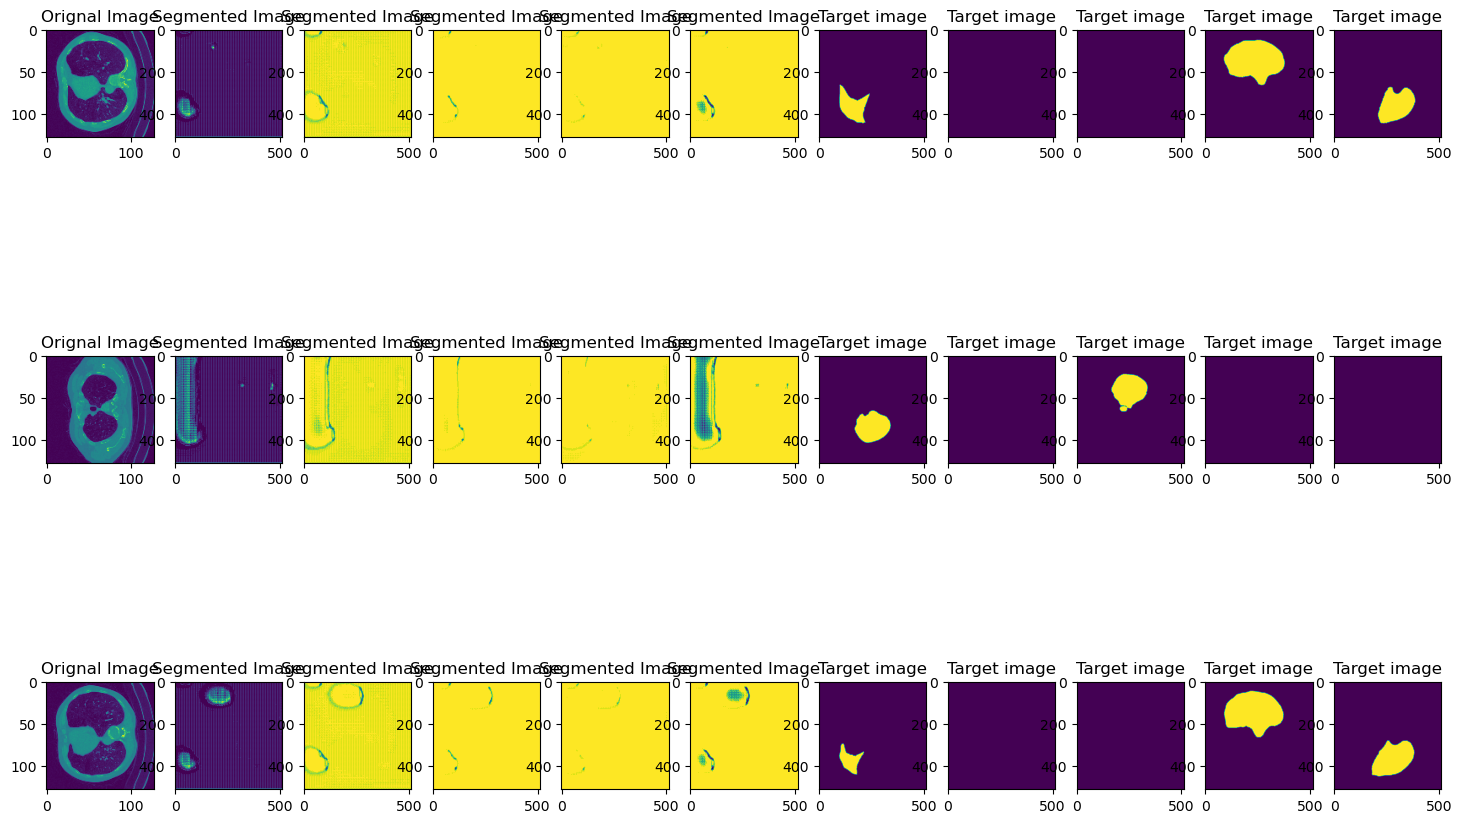

In [159]:
plot_examples(x_train, y_train)

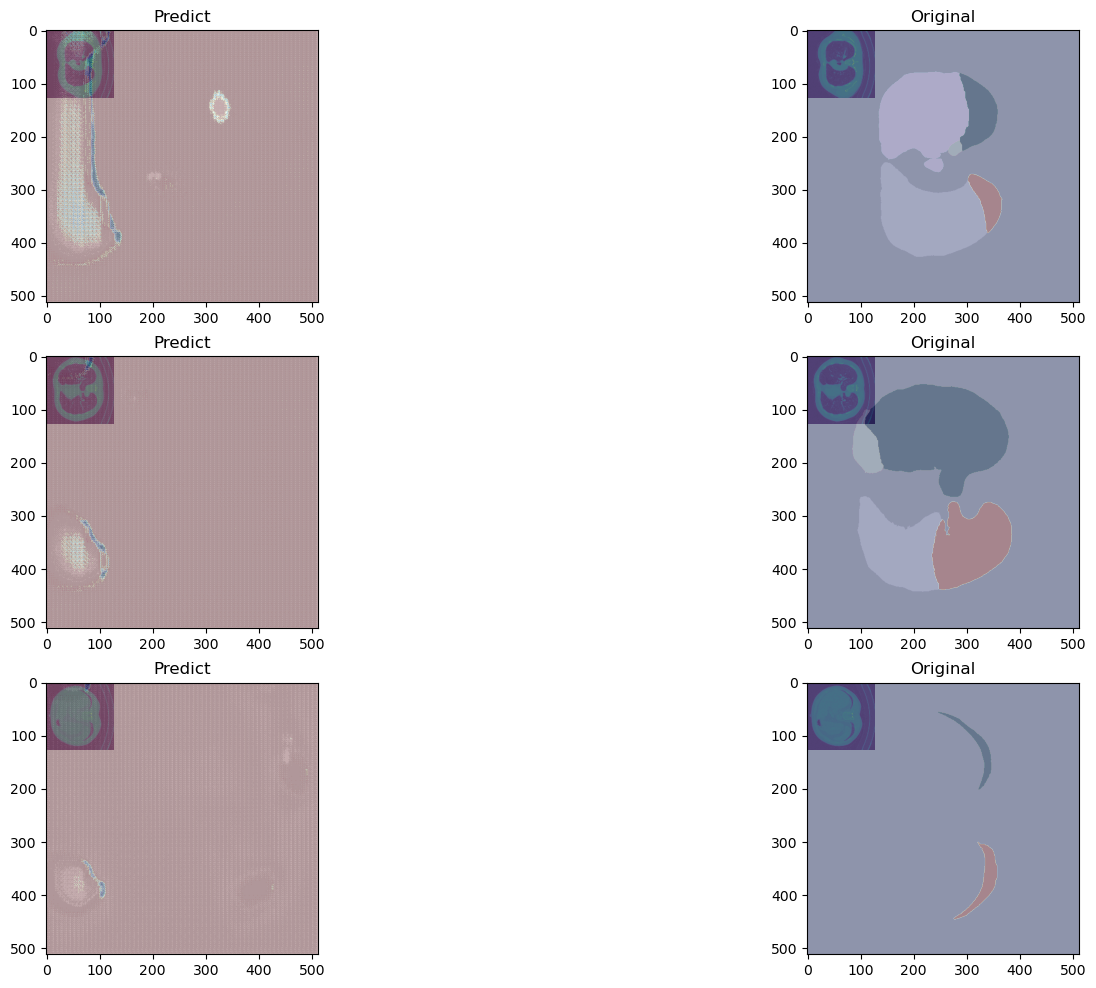

In [158]:
plot_examples_all(x_train, y_train)

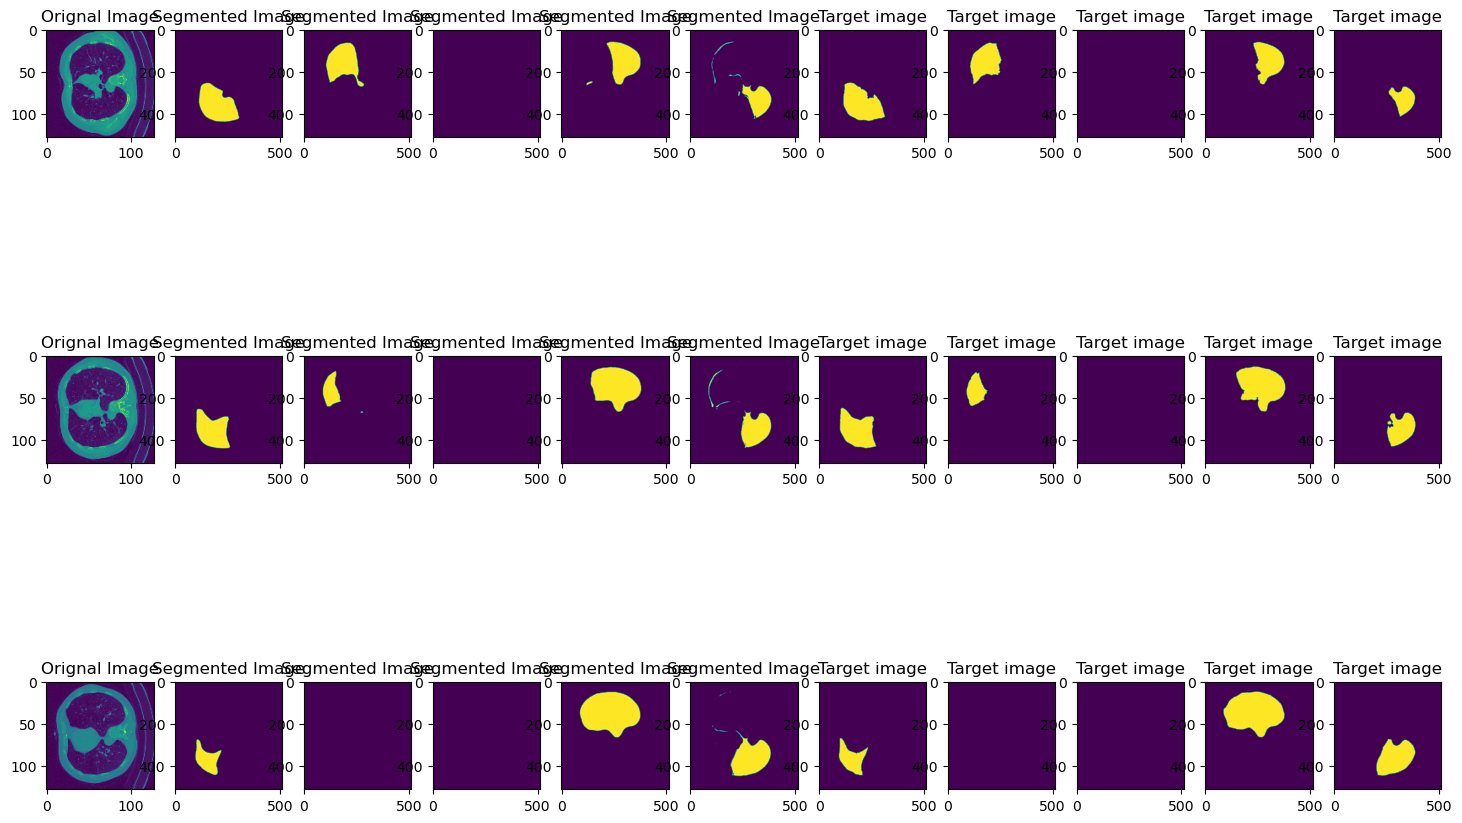

In [109]:
plot_examples(x_train, y_train)

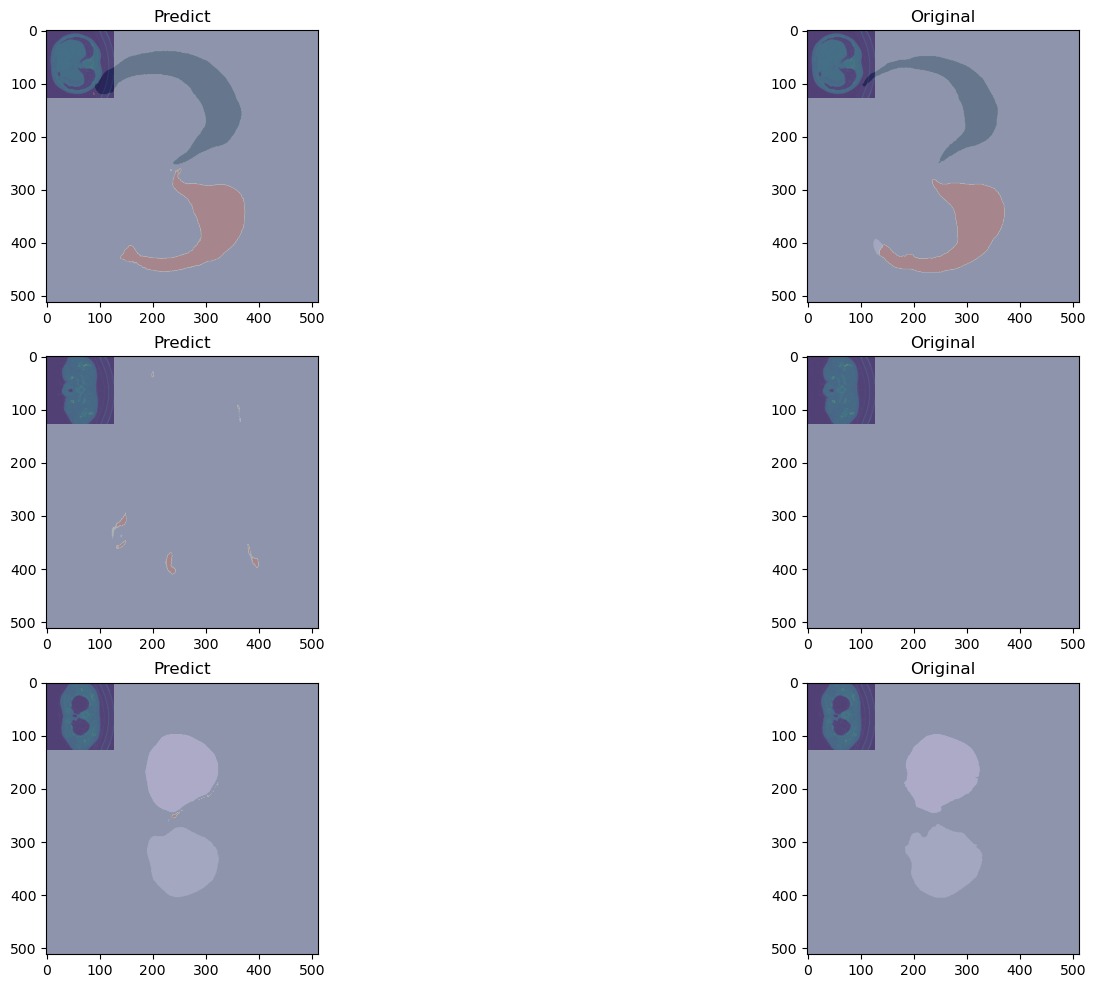

In [113]:
plot_examples_all(x_train, y_train)

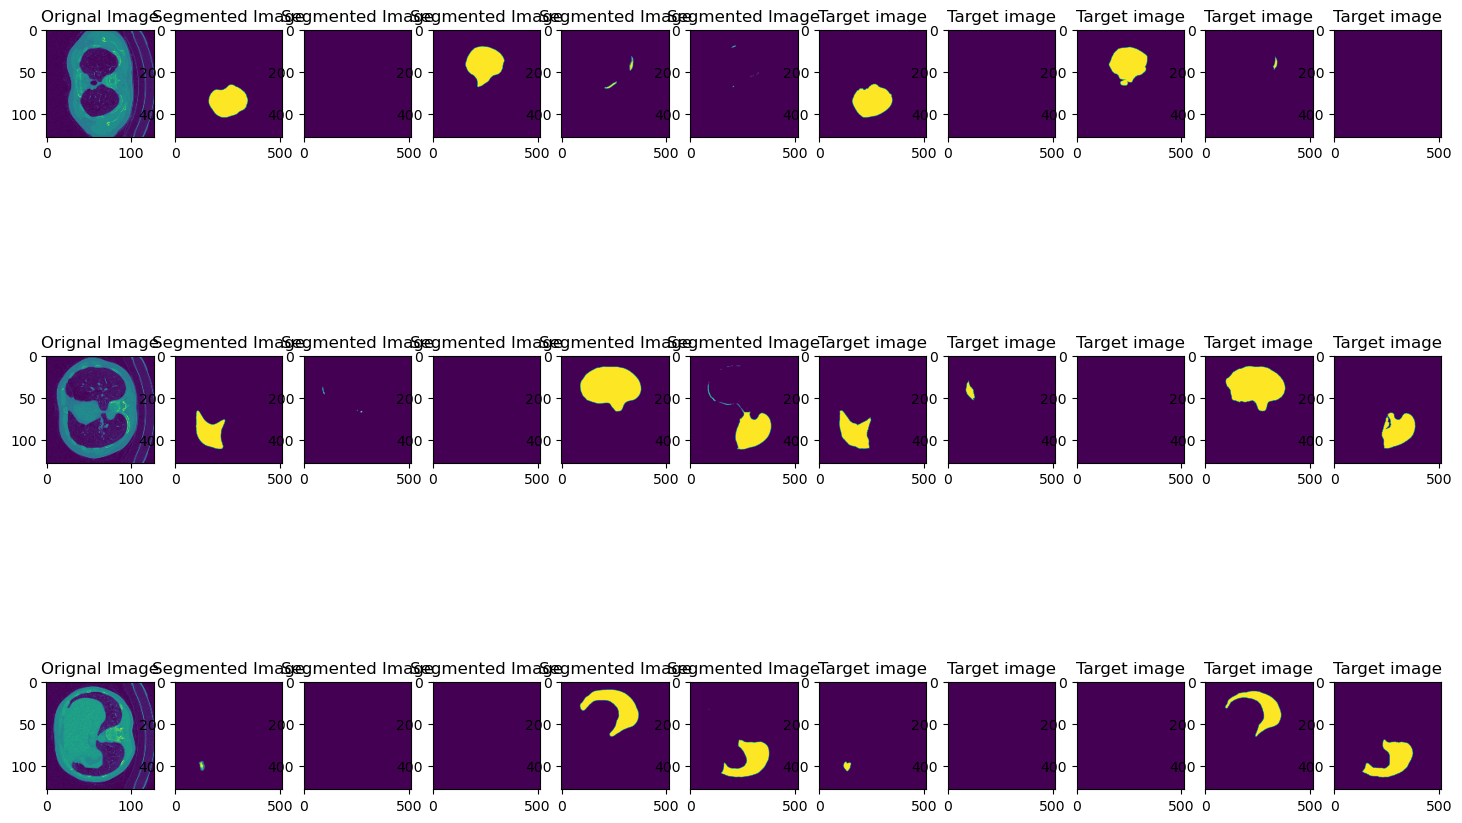

In [107]:
plot_examples(x_val, y_val)

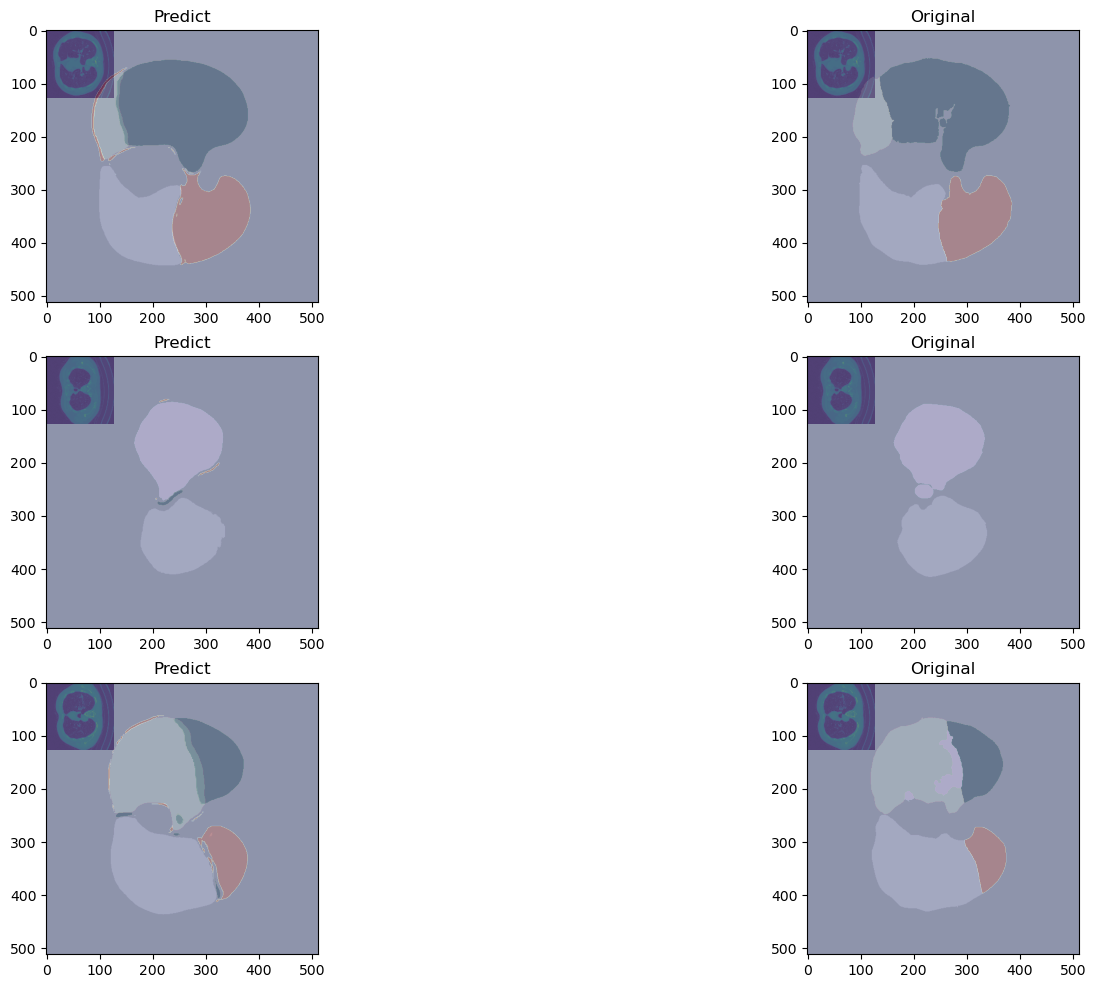

In [116]:
plot_examples_all(x_val, y_val)

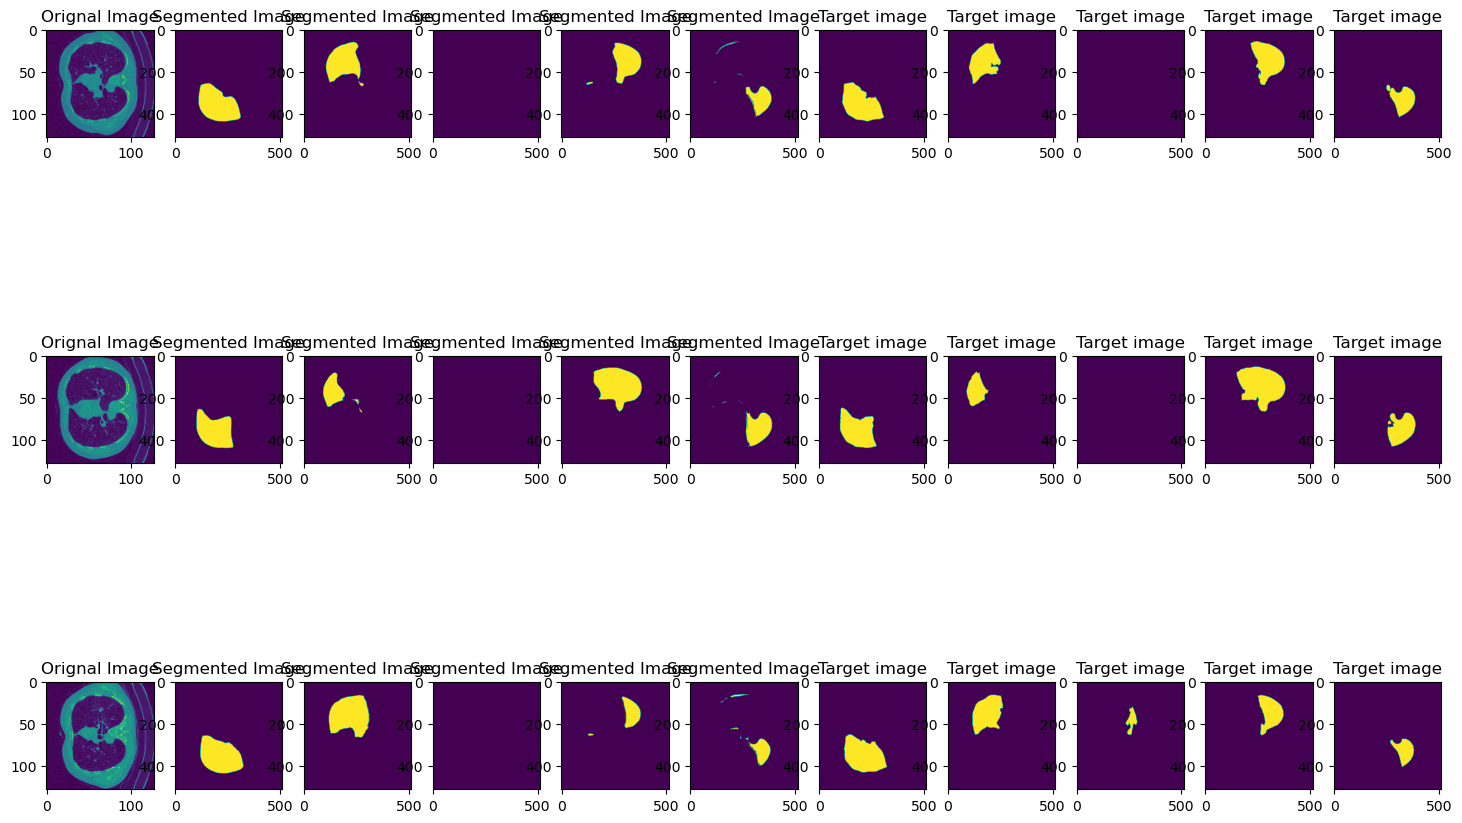

In [84]:
plot_examples(x_train, y_train)

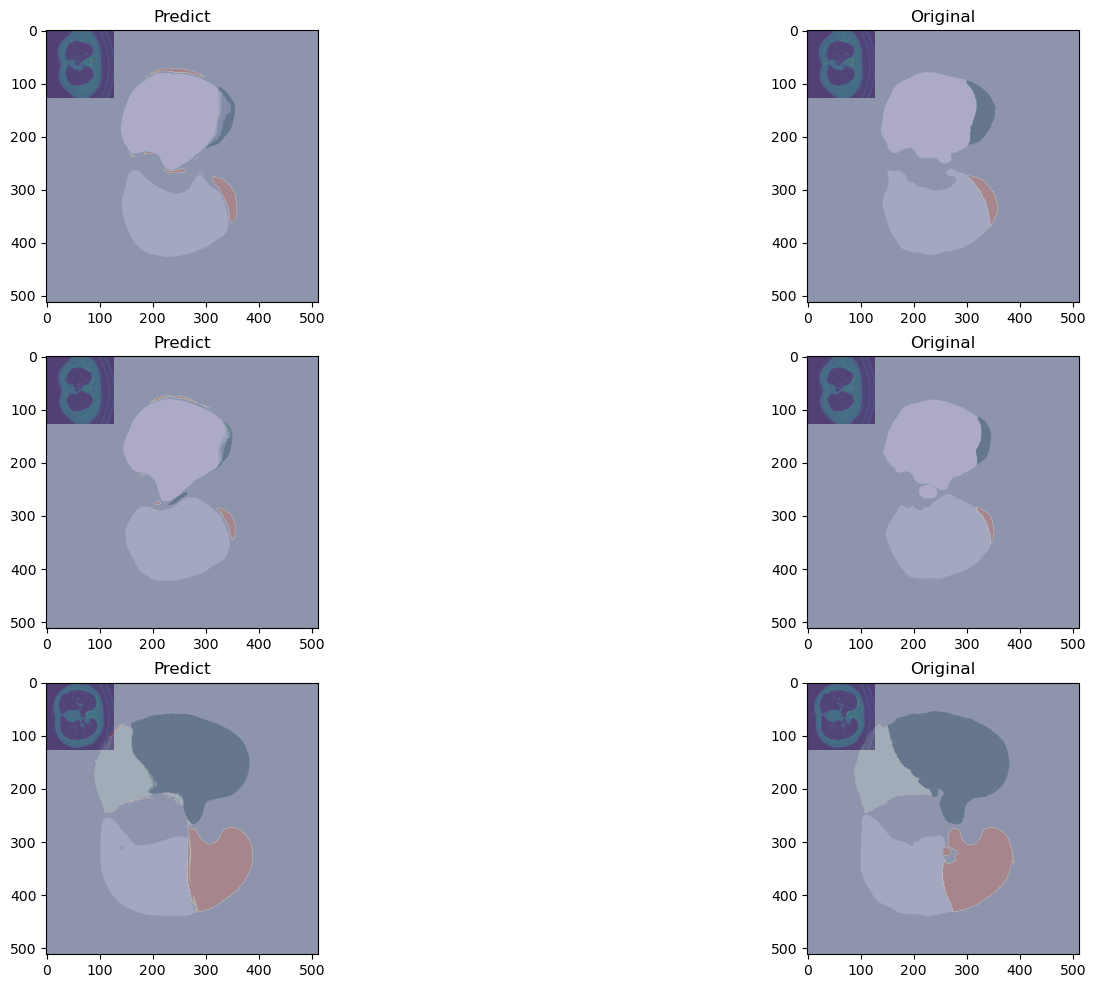

In [95]:
plot_examples_all(x_train, y_train)

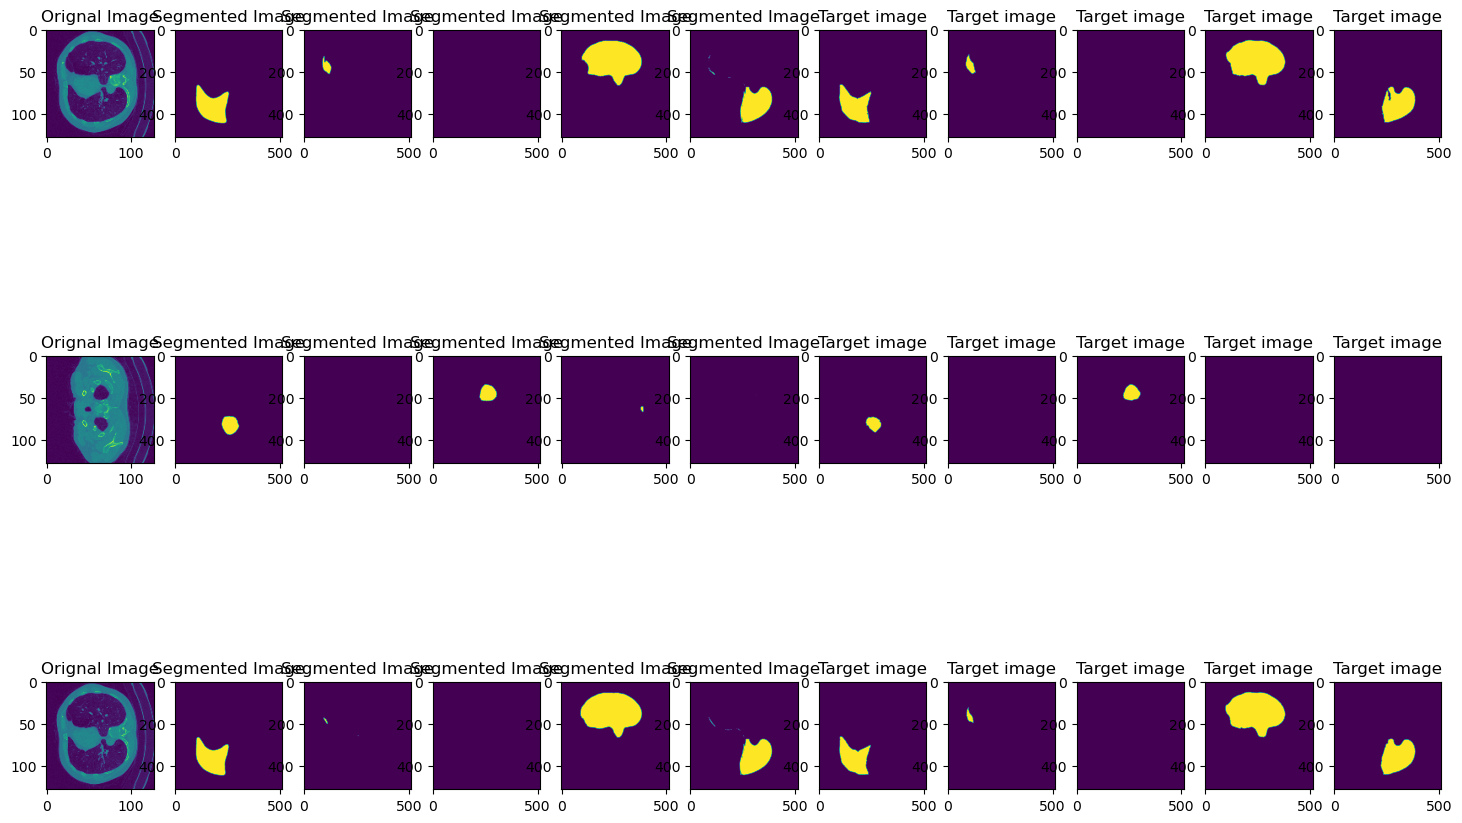

In [97]:
plot_examples(x_val, y_val)

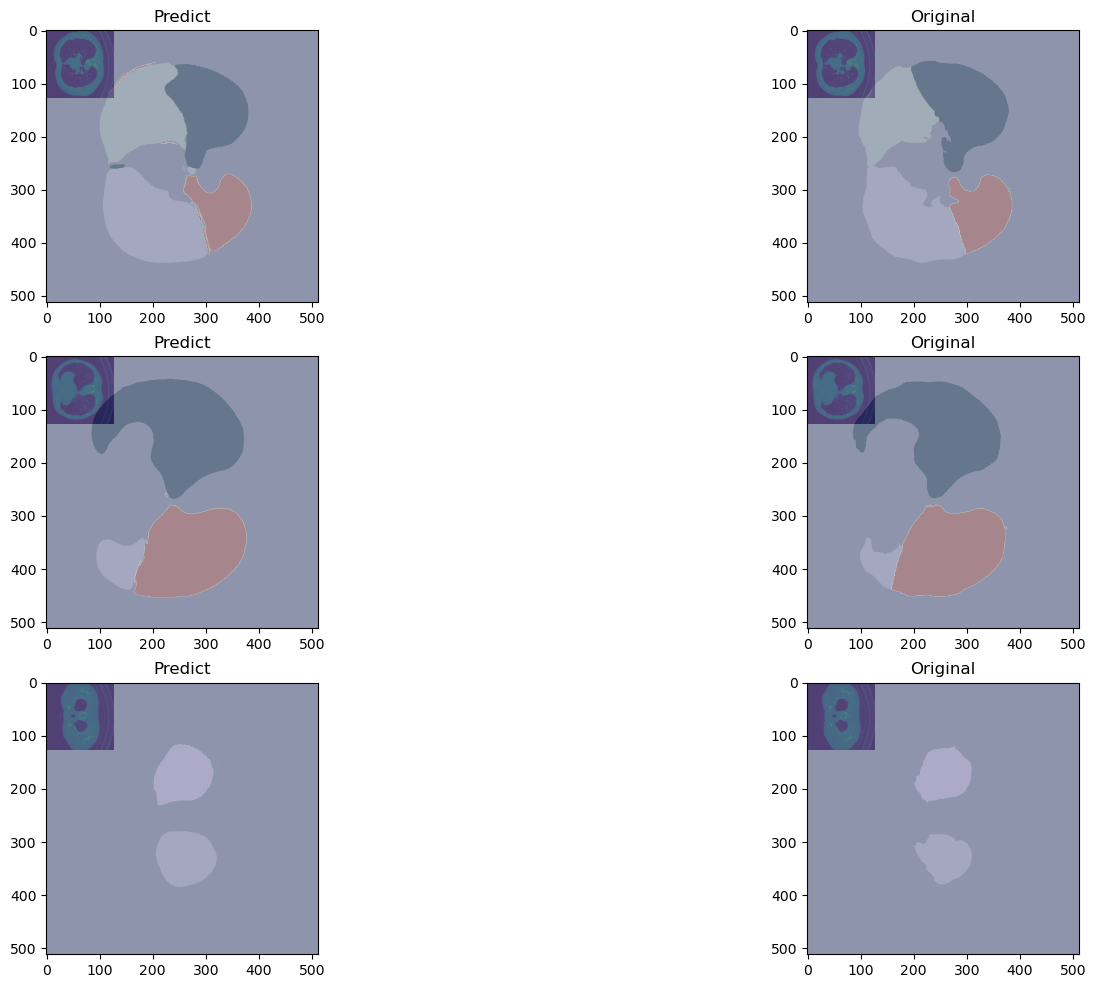

In [98]:
plot_examples_all(x_val, y_val)

In [ ]:
x_val

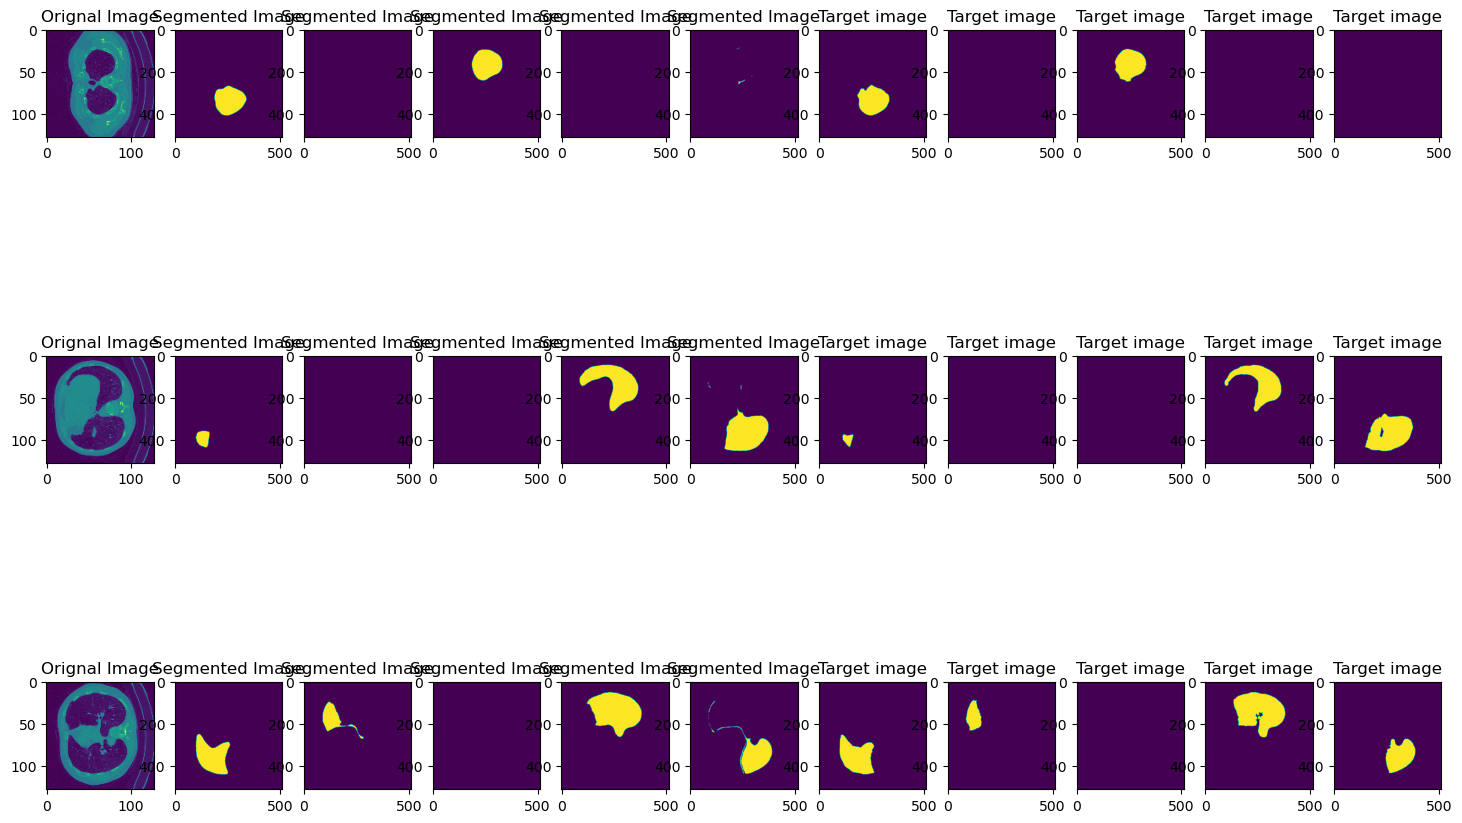

In [77]:
plot_examples(x_train, y_train)

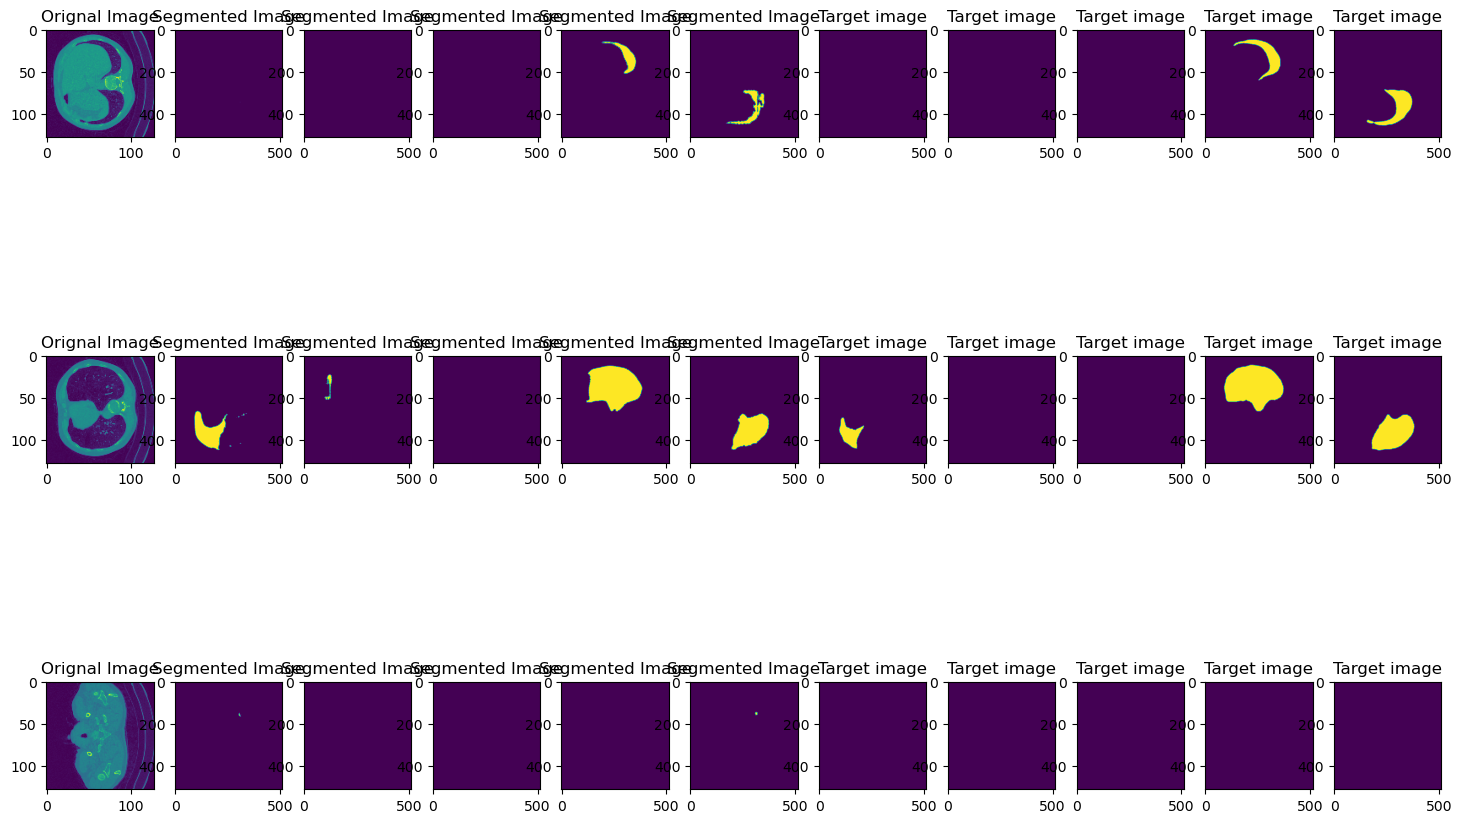

In [78]:
plot_examples(x_train, y_train)

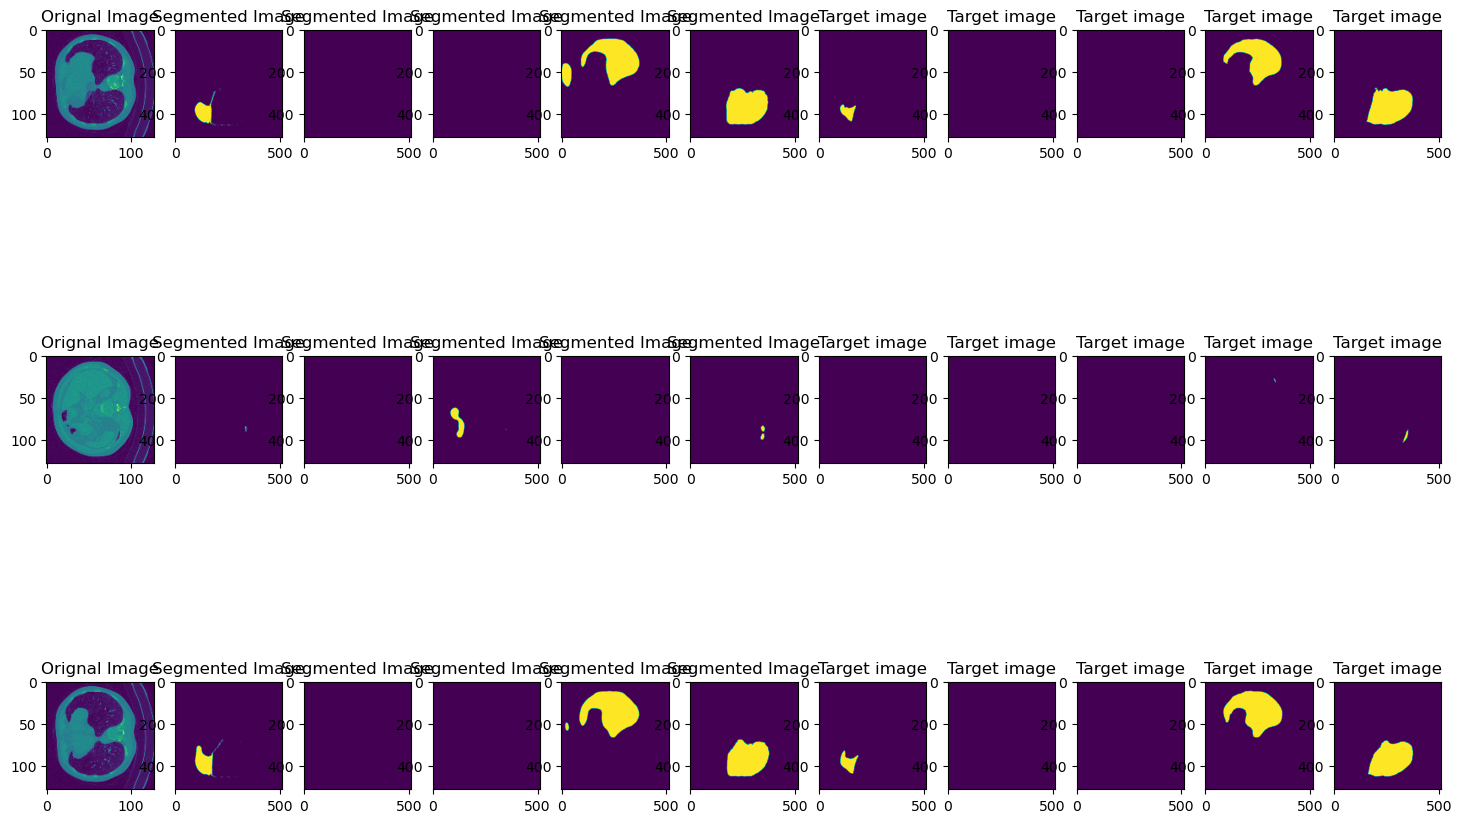

In [66]:
plot_examples(x_train, y_train)

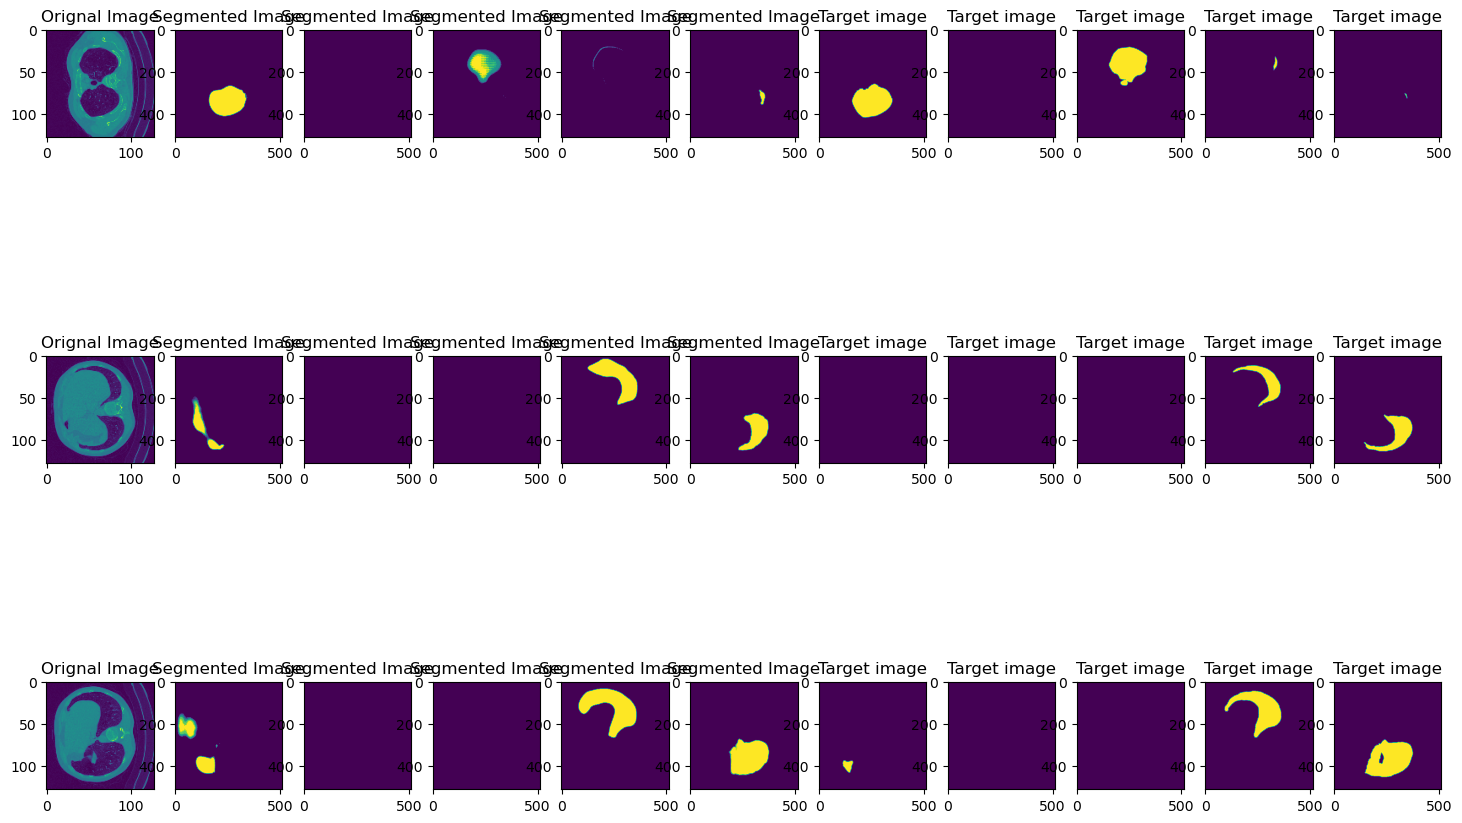

In [64]:
plot_examples(x_train, y_train)

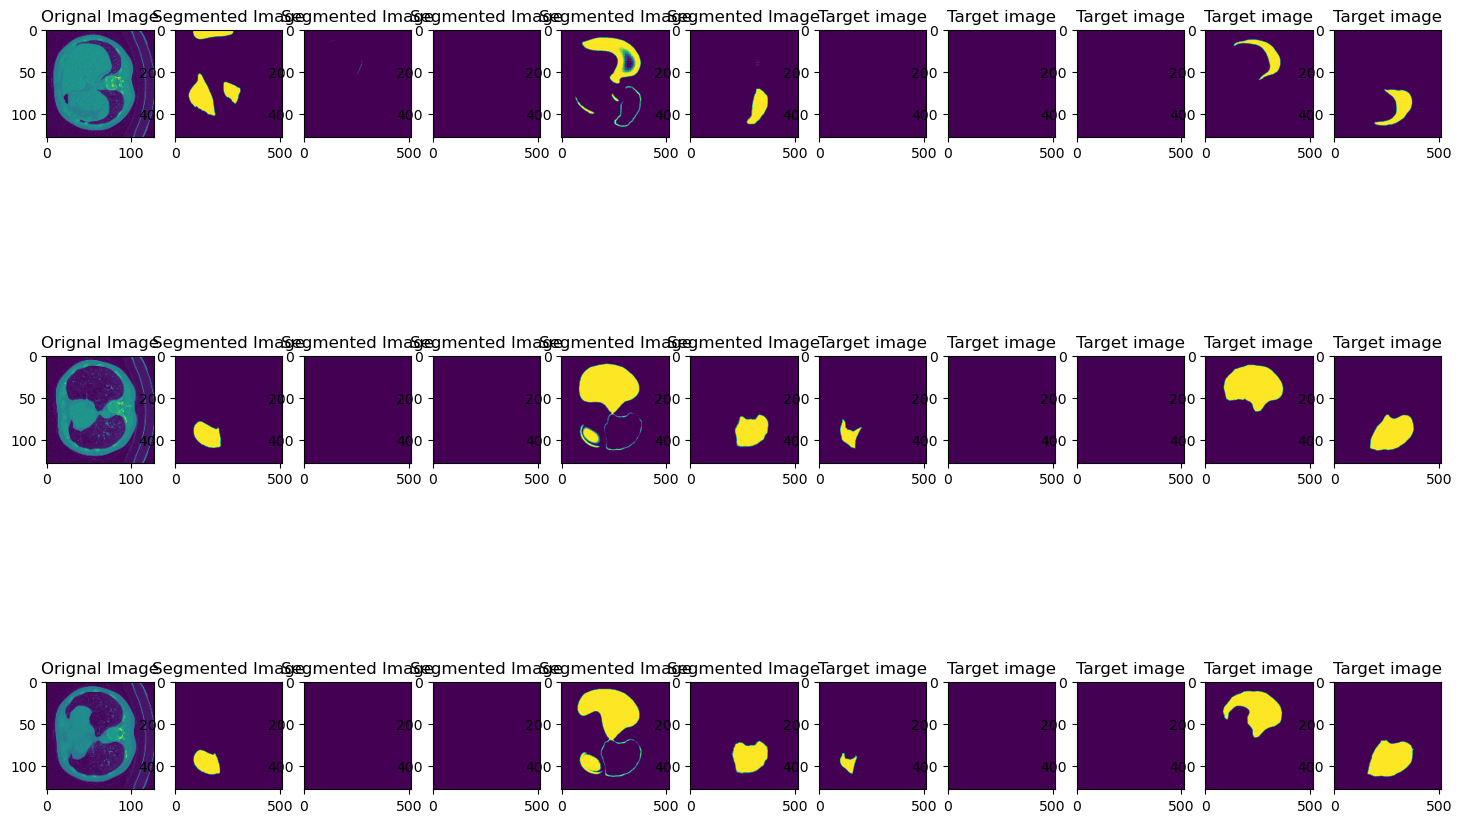

In [62]:
plot_examples(x_train, y_train)